

 <h1>  <center> <b> Speech Systems (EE6307) </b> </center>

<dt> <h4> <b> Programming Assignment - 02 : Analysis and Synthesis of Vowels </b> </h4> </dt>



<dt> <h4>  $\underline{\textbf{Objective}}$:
The objective of this programming assignment (PA) is to analyze the time-domain and frequency-domain characteristics of vowels and to synthesize these vowels using all pole model of speech production.  </h4> </dt>

<dt> <h4>  <b> $\underline{\textbf{Instructions}}$: </b> Please follow these instructions </h4> </dt>
<dd> <h4>  1. Plagiarism is strictly prohibited. </h4> </dd>
<dd> <h4>  2. Delayed submissions will be penalized with a scaling factor of 0.5 per day. </h4> </dd>
<dd> <h4>  3. Please DO NOT use any machine learning libraries unless and otherwise specified. </h4> </dd>
<dd> <h4>  4. You are allowed to use "scipy" library for this PA. </h4> </dd>




<dt> <h4> <b> $\underline{\textbf{Steps}}$: </b> Follow these steps to complete the PA </h4> </dt>


<dt> <h4>  <b> 1. Analysis of vowels: </b>  This part focuses on the analysis of vowels. This PA considers three vowels ('/a/','/e/','/u/').  Your task is to analyze the time-domain and frequency domain characteristics of these three vowels. Clearly report your observations.  </h4> </dt>

<dd> <h4>  - Record the words "hot", "heat", "hoot" </h4> </dd>
<dd> <h4>  - Extract the sustained vowels ('/a/', '/e/', '/u/') from the words "hot," "heat," and "hoot" using the voice activity detection (VAD) module. You may use the VAD module developed in PA1 for this task..  </h4> </dd>
<dd> <h4>  - Analyze the time-domain characteristics of the vowels ('/a/', '/e/', '/u/'). </h4> </dd>
<dd> <h4>  - Analyze the frequency-domain characteristics of the vowels ('/a/', '/e/', '/u/').



 </h4> </dd>

<dt> <h4> <b> 2. Synthesis of vowels: </b> This part focuses on the synthesis of vowels. Assume that speech production can be modeled using an all-pole model. Estimate the parameters of this model and use them to synthesize the vowels. </h4> </dt>







<h4> <center> <b>  Part1 :- Analysis of vowels </center> </b> </h4>

<dt> <h4>  1) Record the words "hot", "heat", "hoot" </h4> </dt>


In [53]:
# Imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
import io
import os
import matplotlib.lines as mlines
from scipy.fft import fft
!pip install pysptk
from pysptk.sptk import lpc

In [ ]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

######################## Module for recording the speech signal ########################
#1. The below code records the speech signal for 3 sec ( you can change the duration of the recording in the code ) and store it as 'recording.wav' <br/>
#2. If you have already recorded or uploaded the file named 'recording.wav', the code uses that file. Otherwise, it records and saves the file with the name 'recording.wav.'



#### Please comment below line, if you already uploaded the 'recording.wav' in '/content/'
# !rm recording.wav

# if os.path.isfile('recording.wav'):
#     print("wavefile exists, later part of the code uses 'recording.wav' as input speech")
#     (rate,sig) = scipy.io.wavfile.read("recording.wav")
#     print(len(sig))
# else:
#     print("There is no file in the current directory, please record your voice")
#     print("Recording started!")
#     wav = record(3.0) #It will record three seconds of your speech
#     wav = wav.set_frame_rate(16000)
#     sig=wav.get_array_of_samples()
#     samples=np.array(sig).T.astype(np.float32)
#     fp_arr = np.array(samples).T.astype(np.float32)
#     fp_arr /= np.iinfo(sig.typecode).max
#     scipy.io.wavfile.write('recording.wav', 16000, fp_arr)
#     plt.plot(fp_arr)
#     plt.show()

In [54]:
def FrameSig(input, rate, frameSize=0.025, frameShift=0.010, window='hamming'):

    '''
    Example :- samplingRate =16000, frameSize= 0.025 sec, frameShift = 0.010 sec
    Input  = (1,16000*5) # The size of the 5 second speech signal with 16 kHz sampling rate
    Output = (500,400) # Here 500 is the number of frames and 400 is the number of samples in the frame
    '''

    frames = []
    start_index = 0

    frame_length = rate * frameSize
    number_frame_shift = rate * frameShift


    while start_index < input.shape[0]:

      start = start_index
      end = int(start_index + frame_length)

      frames.append(input[start:end])
      start_index += int(number_frame_shift)


    return frames

    #####################################

#####################################


def rxx(frame, k):
    """
    Computes the autocorrelation at a given lag k.

    :frame: input frame for which autocorrelation needs to be computed at lag k
    :k: lag
    """

    frame = np.asarray(frame)

    if k < 0:
        k = -k
        frame = frame[::-1]

    # Compute autocorrelation using NumPy's dot product
    if k == 0:
        r_XX = np.dot(frame, frame)
    else:
        r_XX = np.dot(frame[:-k], frame[k:])

    return r_XX

#####################################

#####################################

def AutoCorrelation(frame):
    """
    Takes frame as input and returns auto-correlation sequence of the frame

    :frame:
      frame for which auto-correlation sequence needs to be computed
    """

    k = len(frame) // 2

    shift = np.arange(-k, k+1)

    vectorized_rxx = np.vectorize(lambda k: rxx(frame, k))
    auto_corr = vectorized_rxx(shift)

    if max(auto_corr) == 0:
        return np.zeros(len(auto_corr))

    return auto_corr/max(auto_corr)


#####################################

#####################################

def get_f0(Rxx, rate):
    """
    Returns the fundamental frequency and location of second peak from the auto-correlation sequence

    :Rxx:
      Auto-correlation sequence of the frame

    :rate:
      Sampling rate of the signal
    """

    second_peak = -1

    start_index = len(Rxx) // 2

    peaks = []

    for k in range(start_index + 30 , len(Rxx)- 30):

      if all(Rxx[k] > Rxx[j] for j in range(k - 30, k)) and all(Rxx[k] > Rxx[j] for j in range(k + 1, k + 31)):

        peaks.append(k)

    peaks = sorted(peaks, key = lambda x: Rxx[x], reverse = True)

    second_peak = -1

    if len(peaks) != 0:

        second_peak = peaks[0]

    if second_peak != -1:

        F0 = rate / (second_peak - start_index)

    else:

        F0 = 0

    return (F0,second_peak)

#####################################

#####################################

def VoicedVSUnvoiced(frame, rate, threshold):
    """
    Given a frame , returns whether the frame is voiced or unvoiced
    If the frame is voiced, The code returns the F0 of the voiced frame
    If the frame is unvoiced. The code returns '0' as F0 ( It will help in filtering out unvoiced frames )

    :frame:
      a fixed window of speech signal

    :rate:
      Sampling rate of the signal

    :threshold:
      threshold above which a signal is classified as voiced else unvoiced
    """

    Rxx = AutoCorrelation(frame)

    F0, second_peak = get_f0(Rxx, rate)

    voiced = 1

    if Rxx[second_peak] < threshold or F0 == 0:

      voiced = 0

    return voiced, F0

#####################################

In [55]:
def VoiceRegions(sig, rate, frameSize = 0.025, frameShift = 0.010, PeakThreshold = 0.6):

  Frames = FrameSig(sig, rate, frameSize, frameShift)

  voiced_frames = []

  for index, frame in enumerate(Frames):

    if VoicedVSUnvoiced(frame, rate, PeakThreshold)[0] == 1:

      voiced_frames.append(index)


  return voiced_frames

#####################################

#####################################

def longest_contiguous_sequence(nums):
    if not nums:
        return []

    nums.sort()  # Sort the list
    longest_seq = []
    current_seq = [nums[0]]

    for i in range(1, len(nums)):
        if nums[i] == nums[i - 1] + 1:
            current_seq.append(nums[i])  # Continue the current sequence
        else:
            if len(current_seq) > len(longest_seq):
                longest_seq = current_seq  # Update the longest sequence
            current_seq = [nums[i]]  # Start a new sequence

    # Check the last sequence
    if len(current_seq) > len(longest_seq):
        longest_seq = current_seq

    return longest_seq

def Extract1D(sig, rate, frameSize = 0.025, frameShift = 0.010, PeakThreshold = 0.6):

  Frames = FrameSig(sig, rate, frameSize, frameShift)

  voiced_tags = VoiceRegions(sig, rate, frameSize, frameShift, PeakThreshold)

  voiced_index = longest_contiguous_sequence(voiced_tags)

  start_frame = voiced_index[0]
  end_frame = voiced_index[-1]

  number_frame_shift = int(rate * frameShift)
  frame_length = int(rate * frameSize)

  return sig[start_frame*number_frame_shift : end_frame*number_frame_shift + frame_length]

#####################################



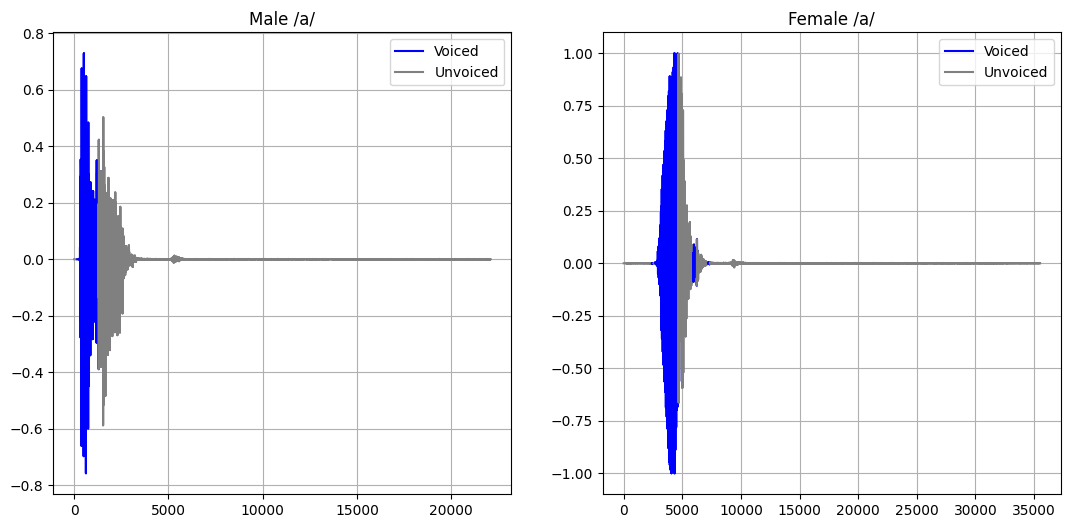

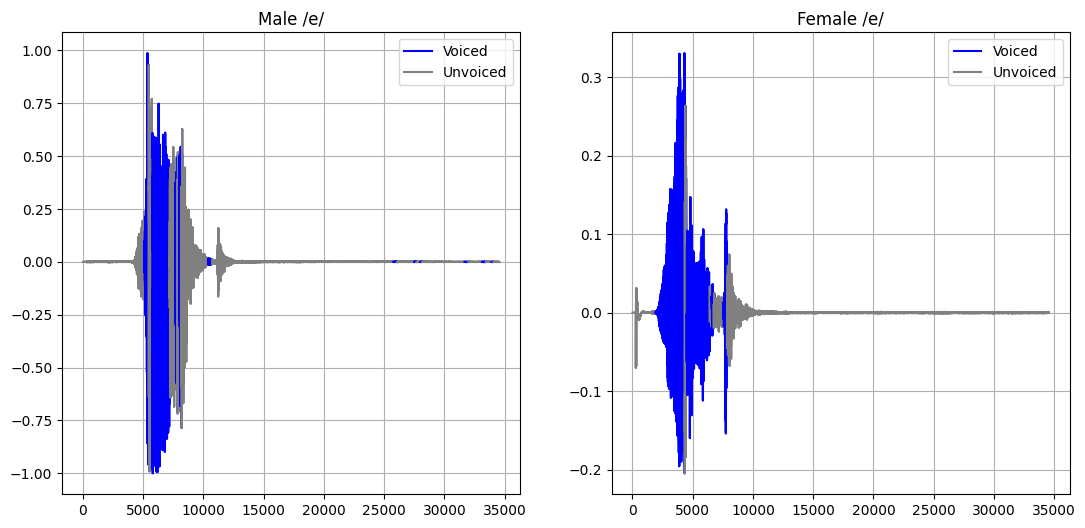

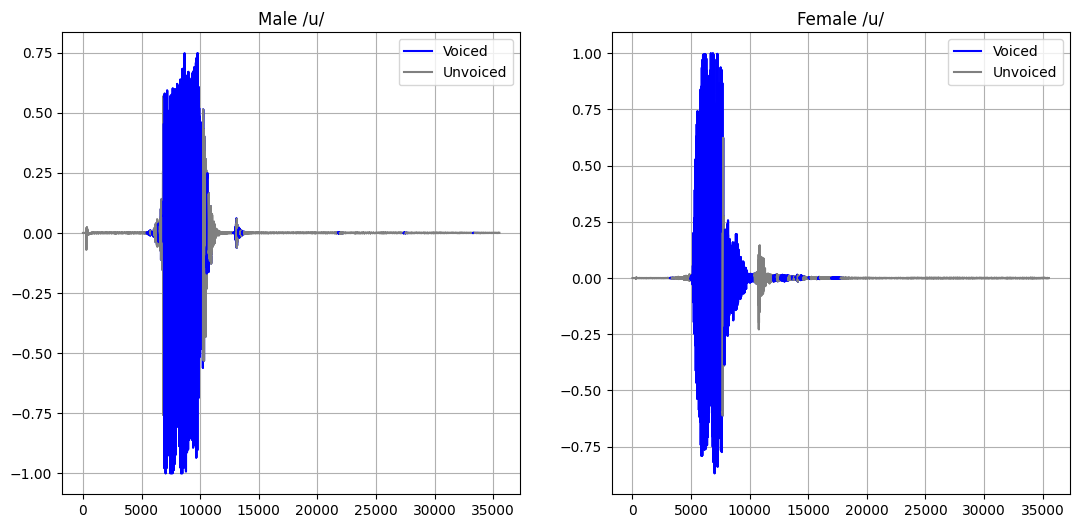

In [56]:
#Load the recorded speech signal

for vowel in ['a', 'e', 'u']:

  (recording,rate) = sf.read(f'male_{vowel}.wav')
  (f_recording,rate) = sf.read(f'female_{vowel}.wav')

  frameSize = 0.025
  frameShift = 0.010
  windowing = 'hamming'
  Frames = FrameSig(recording, rate, frameSize, frameShift, windowing)
  f_Frames = FrameSig(f_recording, rate, frameSize, frameShift, windowing)
  PeakThreshold = 0.5
  decision = [0]*len(Frames)
  f_decision = [0]*len(f_Frames)

  for index, Frame in enumerate(Frames):


    VoicedDecision, EstimatedF0=VoicedVSUnvoiced(Frame, rate, PeakThreshold)

    if VoicedDecision == 1:

      decision[index] = 1

  for index, Frame in enumerate(f_Frames):


    VoicedDecision, EstimatedF0=VoicedVSUnvoiced(Frame, rate, PeakThreshold)

    if VoicedDecision == 1:

      f_decision[index] = 1

  def color(decision):

    if decision == 1:

      return 'blue'

    else:

      return 'grey'


  frameShift = int(rate * 0.010)
  frameSize = int(rate * 0.025)

  frame_decision = {}

  fig, axes = plt.subplots(1, 2, figsize=(13, 6))

  for index, frame in enumerate(Frames):

      if index*frameShift + frameSize >  len(recording):

        axes[0].plot(range(index*frameShift, len(recording)), recording[index*frameShift:], color = color(decision[index]))
        continue

      axes[0].plot(range(index*frameShift, index*frameShift + frameSize), recording[index*frameShift: index*frameShift + frameSize], color = color(decision[index]))

  blue_line = mlines.Line2D([], [], color='blue', label='Voiced')
  grey_line = mlines.Line2D([], [], color='grey', label='Unvoiced')

  axes[0].legend(handles=[blue_line, grey_line])
  axes[0].set_title(f'Male /{vowel}/')
  axes[0].grid()


  for index, frame in enumerate(f_Frames):

    if index*frameShift + frameSize >  len(f_recording):

      axes[1].plot(range(index*frameShift, len(f_recording)), f_recording[index*frameShift:], color = color(f_decision[index]))
      continue

    axes[1].plot(range(index*frameShift, index*frameShift + frameSize), f_recording[index*frameShift: index*frameShift + frameSize], color = color(f_decision[index]))

  blue_line = mlines.Line2D([], [], color='blue', label='Voiced')
  grey_line = mlines.Line2D([], [], color='grey', label='Unvoiced')

  axes[1].legend(handles=[blue_line, grey_line])
  axes[1].set_title(f'Female /{vowel}/')
  axes[1].grid()



<dt> <h4> 2) Extract the sustained vowels ('/a/', '/e/', '/u/') from the words "hot," "heat," and "hoot" </dt> </h4>

In [119]:
#Load the recorded speech signal
(recording_a,rate) = sf.read('male_a.wav')
(recording_e,rate) = sf.read('male_e.wav')
(recording_u,rate) = sf.read('male_u.wav')

#Run your voice activity detector build in programming assignment1 to detect voiced frames
voiced_a = VoiceRegions(recording_a,rate)
voiced_e = VoiceRegions(recording_e,rate)
voiced_u = VoiceRegions(recording_u,rate)

#Extract 1 dimensional signal using voiced tags of the frames
sustained_a = Extract1D(recording_a, rate)
sustained_e = Extract1D(recording_e, rate)
sustained_u = Extract1D(recording_u, rate)

#Load the recorded speech signal
(f_recording_a,rate) = sf.read('female_a.wav')
(f_recording_e,rate) = sf.read('female_e.wav')
(f_recording_u,rate) = sf.read('female_u.wav')

#Run your voice activity detector build in programming assignment1 to detect voiced frames
f_voiced_a = VoiceRegions(f_recording_a,rate)
f_voiced_e = VoiceRegions(f_recording_e,rate)
f_voiced_u = VoiceRegions(f_recording_u,rate)

#Extract 1 dimensional signal using voiced tags of the frames
f_sustained_a = Extract1D(f_recording_a, rate)
f_sustained_e = Extract1D(f_recording_e, rate)
f_sustained_u = Extract1D(f_recording_u, rate)

<dt> <h4>  3) Analyze the time-domain characteristics of the vowels ('/a/', '/e/', '/u/'). </h4> </dt>




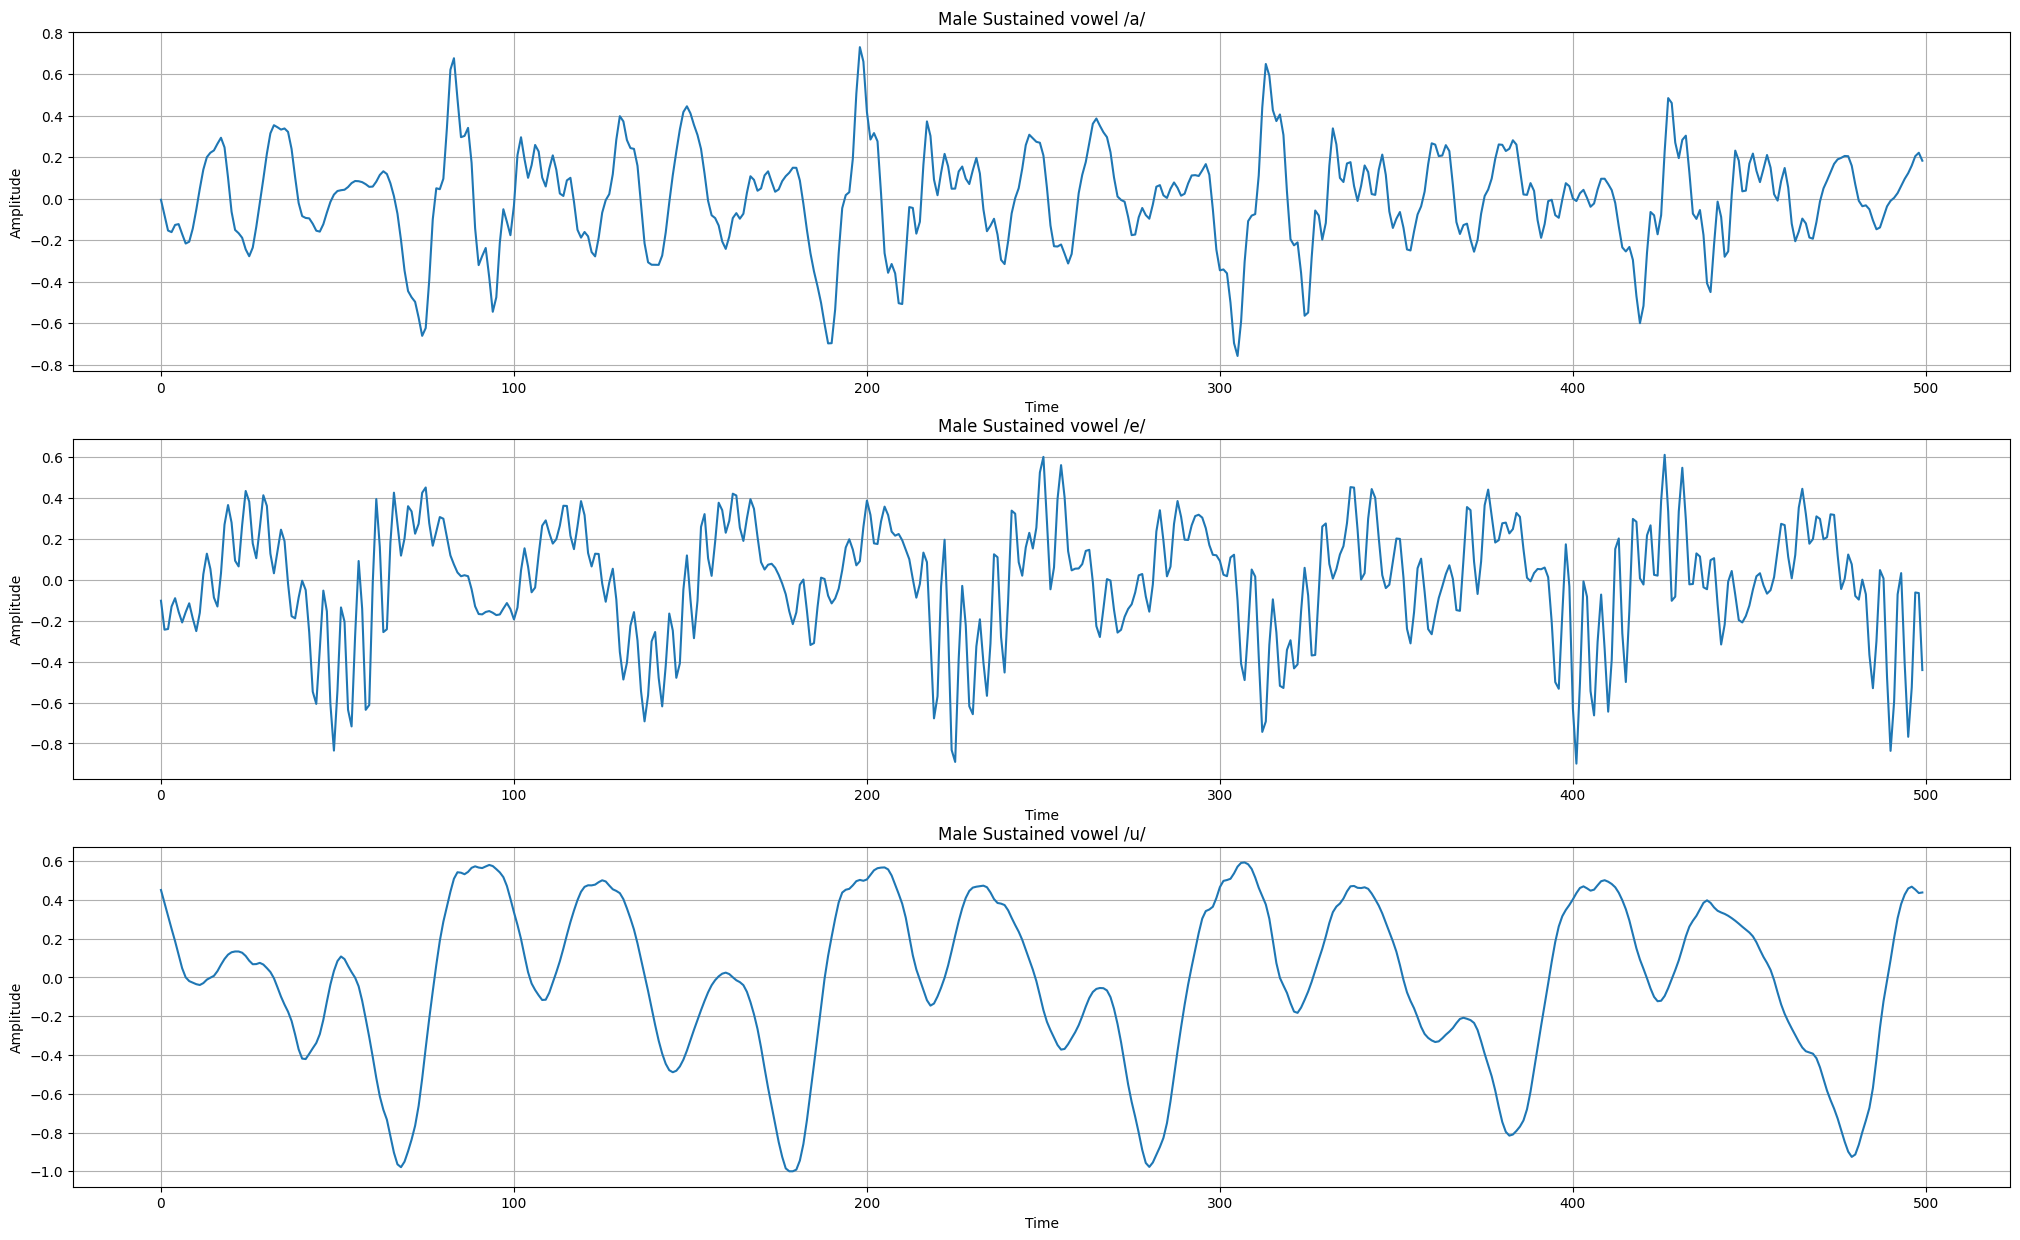

In [118]:
fig, axes = plt.subplots(3, 1, figsize=(25, 15))

# Plot for sustained vowel /a/
axes[0].plot(sustained_a[:500])
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Male Sustained vowel /a/")
axes[0].grid()

# Plot for sustained vowel /e/
axes[1].plot(sustained_e[:500])
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Male Sustained vowel /e/")
axes[1].grid()

# Plot for sustained vowel /u/
axes[2].plot(sustained_u[:500])
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Male Sustained vowel /u/")
axes[2].grid()

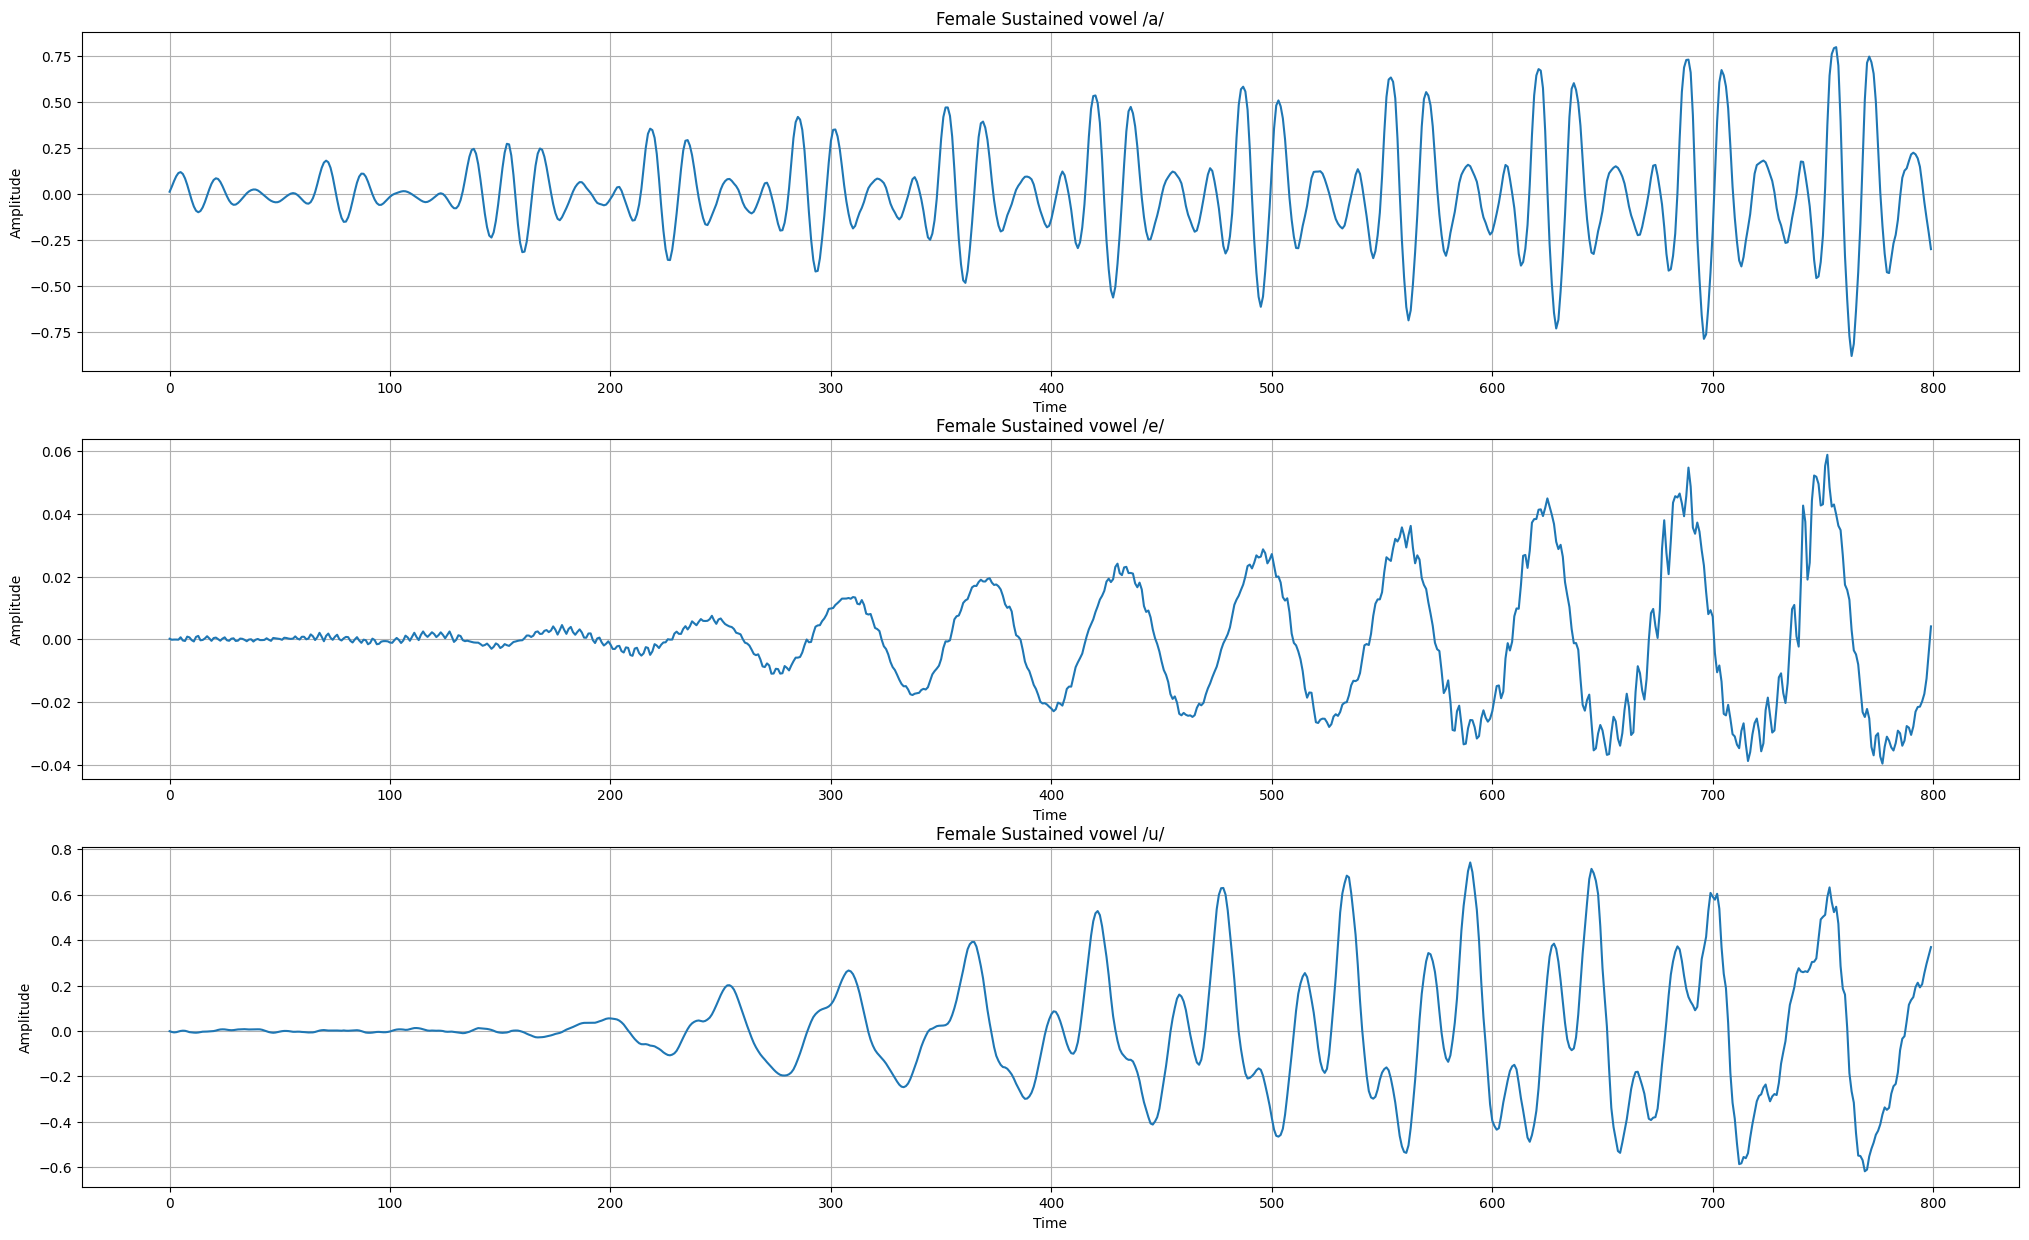

In [120]:
fig, axes = plt.subplots(3, 1, figsize=(25, 15))

# Plot for sustained vowel /a/
axes[0].plot(f_sustained_a[:800])
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Female Sustained vowel /a/")
axes[0].grid()

# Plot for sustained vowel /e/
axes[1].plot(f_sustained_e[:800])
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Female Sustained vowel /e/")
axes[1].grid()

# Plot for sustained vowel /u/
axes[2].plot(f_sustained_u[:800])
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Female Sustained vowel /u/")
axes[2].grid()


<dt> <h4>  4) Analyze the frequency-domain characteristics of the vowels ('/a/', '/e/', '/u/'). </h4> </dt>

<dd> <h4>  - Compute magnitude spectra.  </h4> </dd>
<dd> <h4>  - Manually identify the formants </h4> </dd>
<dd> <h4>  - Observe the effect of spectral sampling of male and female speakers </h4> </dd>
<dd> <h4>  - Observe the effect of window size - 32 ms, 16 ms and 8 ms</h4> </dd>
<dd> <h4>  - How can you estimate $F_{0}$ from magnitude spectrum </h4> </dd>




In [79]:
#####################################

####################################

def DFT(frame):

  transform_frame = np.zeros(len(frame), dtype = complex)

  for i in range(len(frame)):

    for j in range(len(frame)):

      transform_frame[i] += frame[j]*np.exp(-2j*np.pi*i*j/len(frame))

  return transform_frame

#####################################

#####################################

def Spectra(frame):

    #Compute the spectra of the given speech signal
    return 20*np.log(np.abs(fft(frame))) # Can use DFT function mentioned above instead of fft

#####################################

#####################################


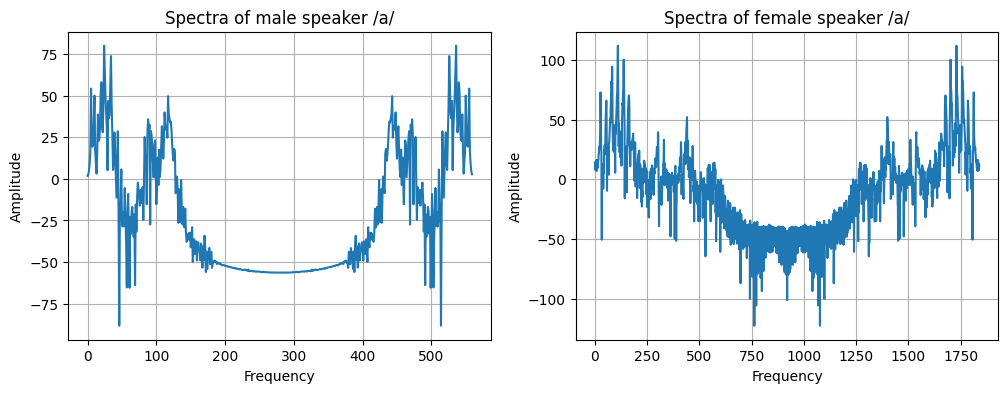

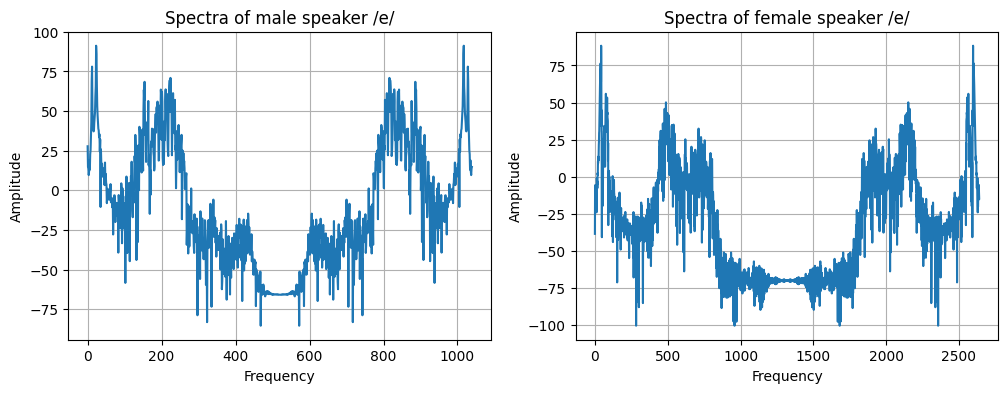

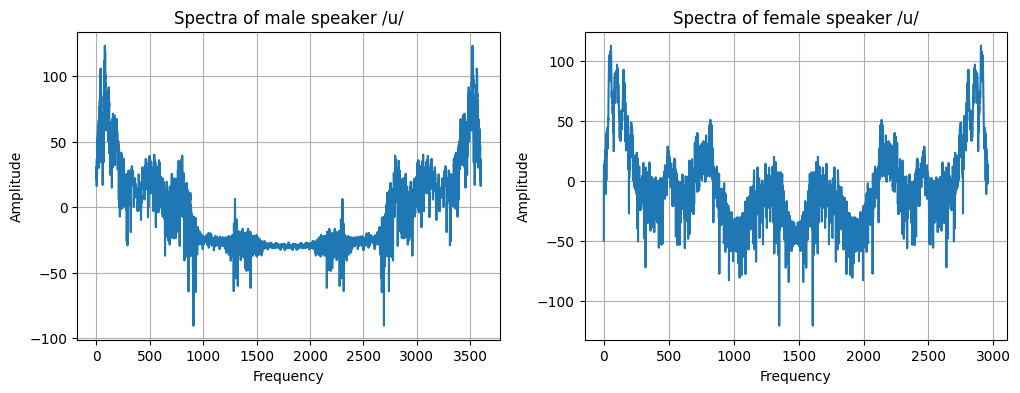

In [80]:
for vowel in ['a', 'e', 'u']:

  male_recording =  f"male_{vowel}.wav"
  female_recording = f"female_{vowel}.wav"

  #Loading male and female speaker recordings
  (male_signal, rate) = sf.read(male_recording)
  (female_signal, rate) = sf.read(female_recording)


  #Extract vowel regions from the loaded signals
  male = Extract1D(male_signal, rate)
  female = Extract1D(female_signal,rate)

  male_spectra = Spectra(male)
  female_spectra = Spectra(female)

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  # Plot the male spectra on the first subplot
  axes[0].plot(male_spectra)
  axes[0].set_xlabel("Frequency")
  axes[0].set_ylabel("Amplitude")
  axes[0].set_title(f"Spectra of male speaker /{vowel}/")
  axes[0].grid()

  # Plot the female spectra on the second subplot
  axes[1].plot(female_spectra)
  axes[1].set_xlabel("Frequency")
  axes[1].set_ylabel("Amplitude")
  axes[1].set_title(f"Spectra of female speaker /{vowel}/")
  axes[1].grid()

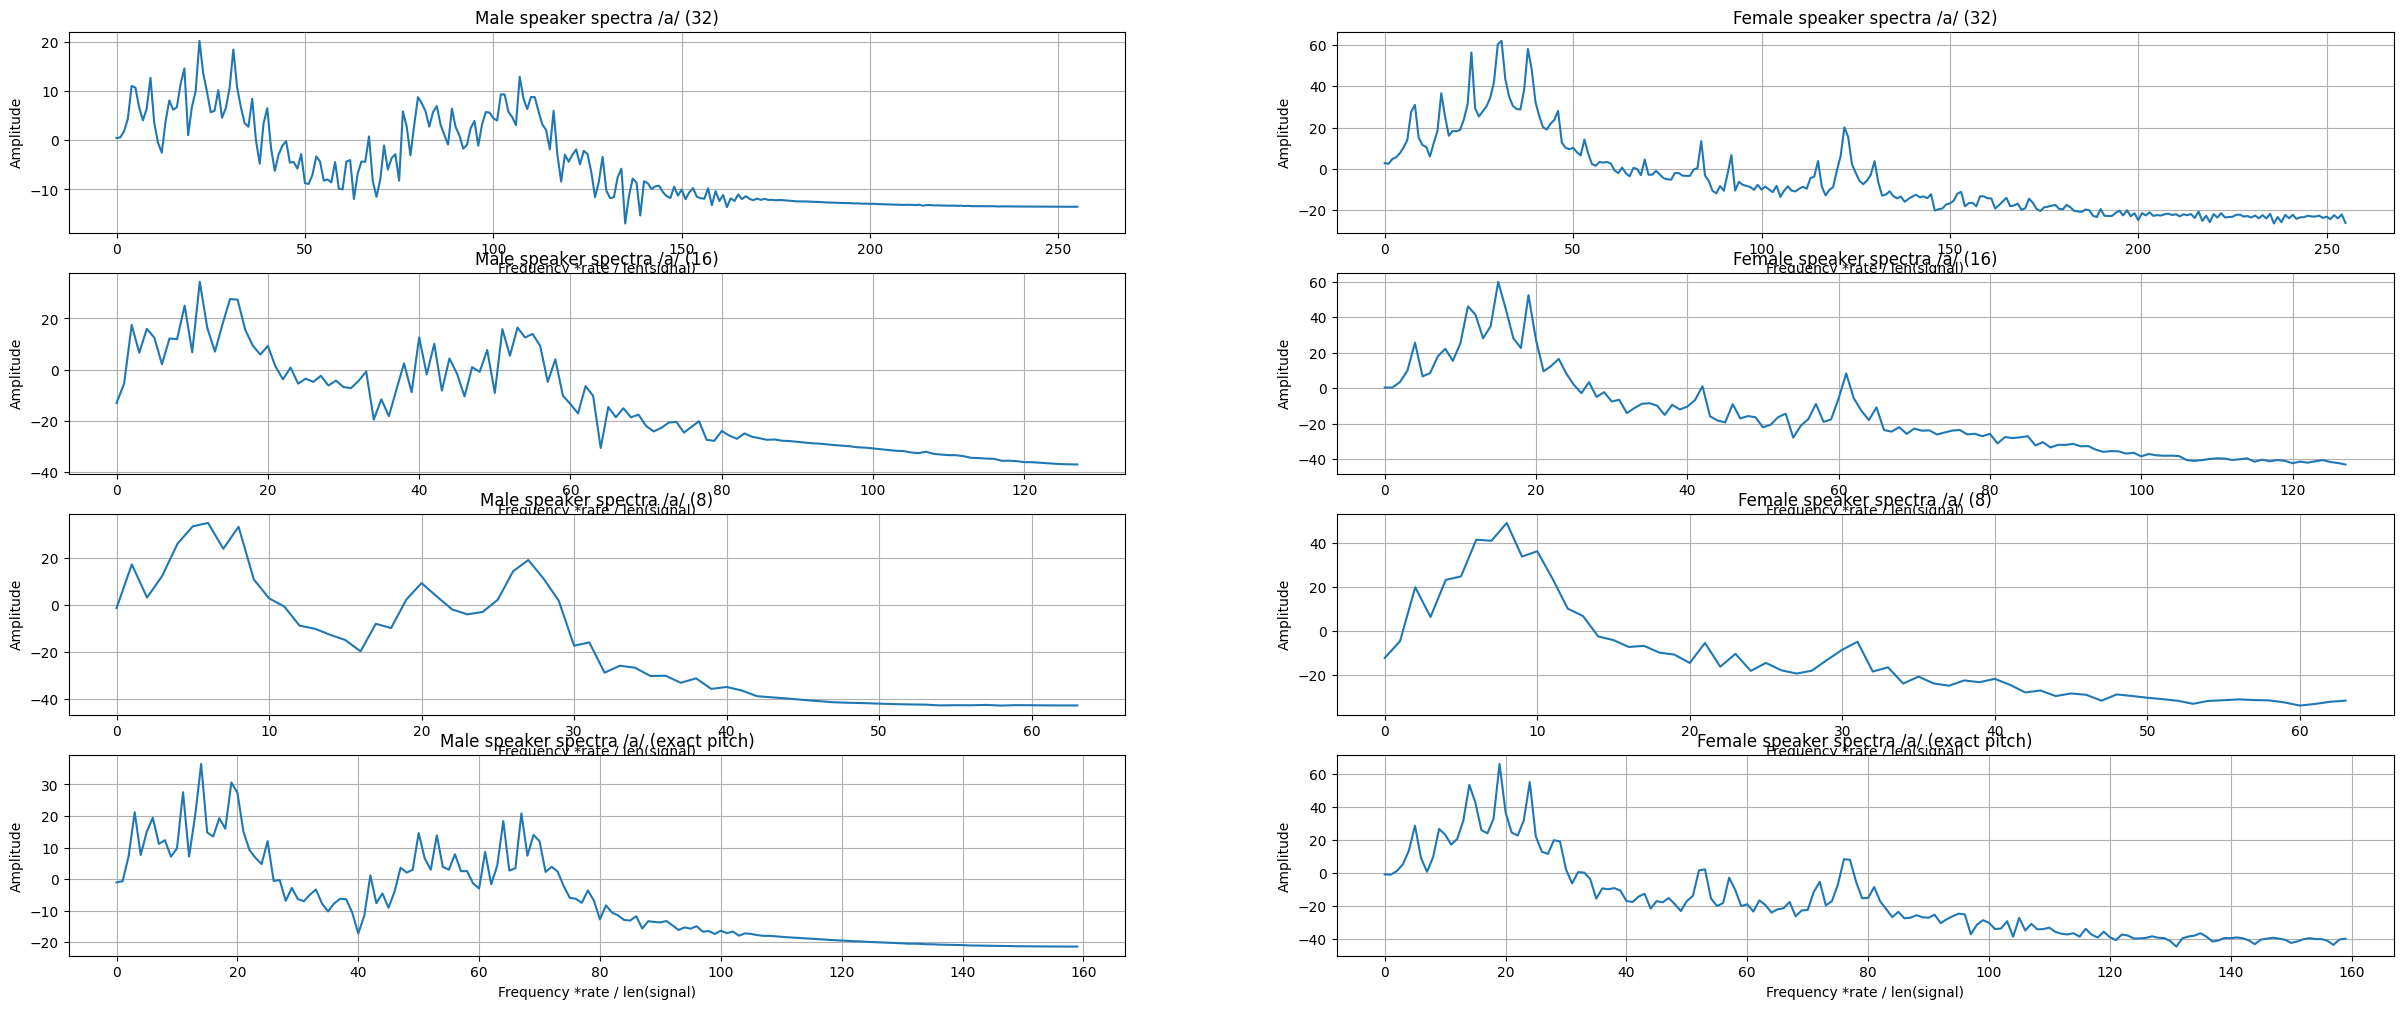

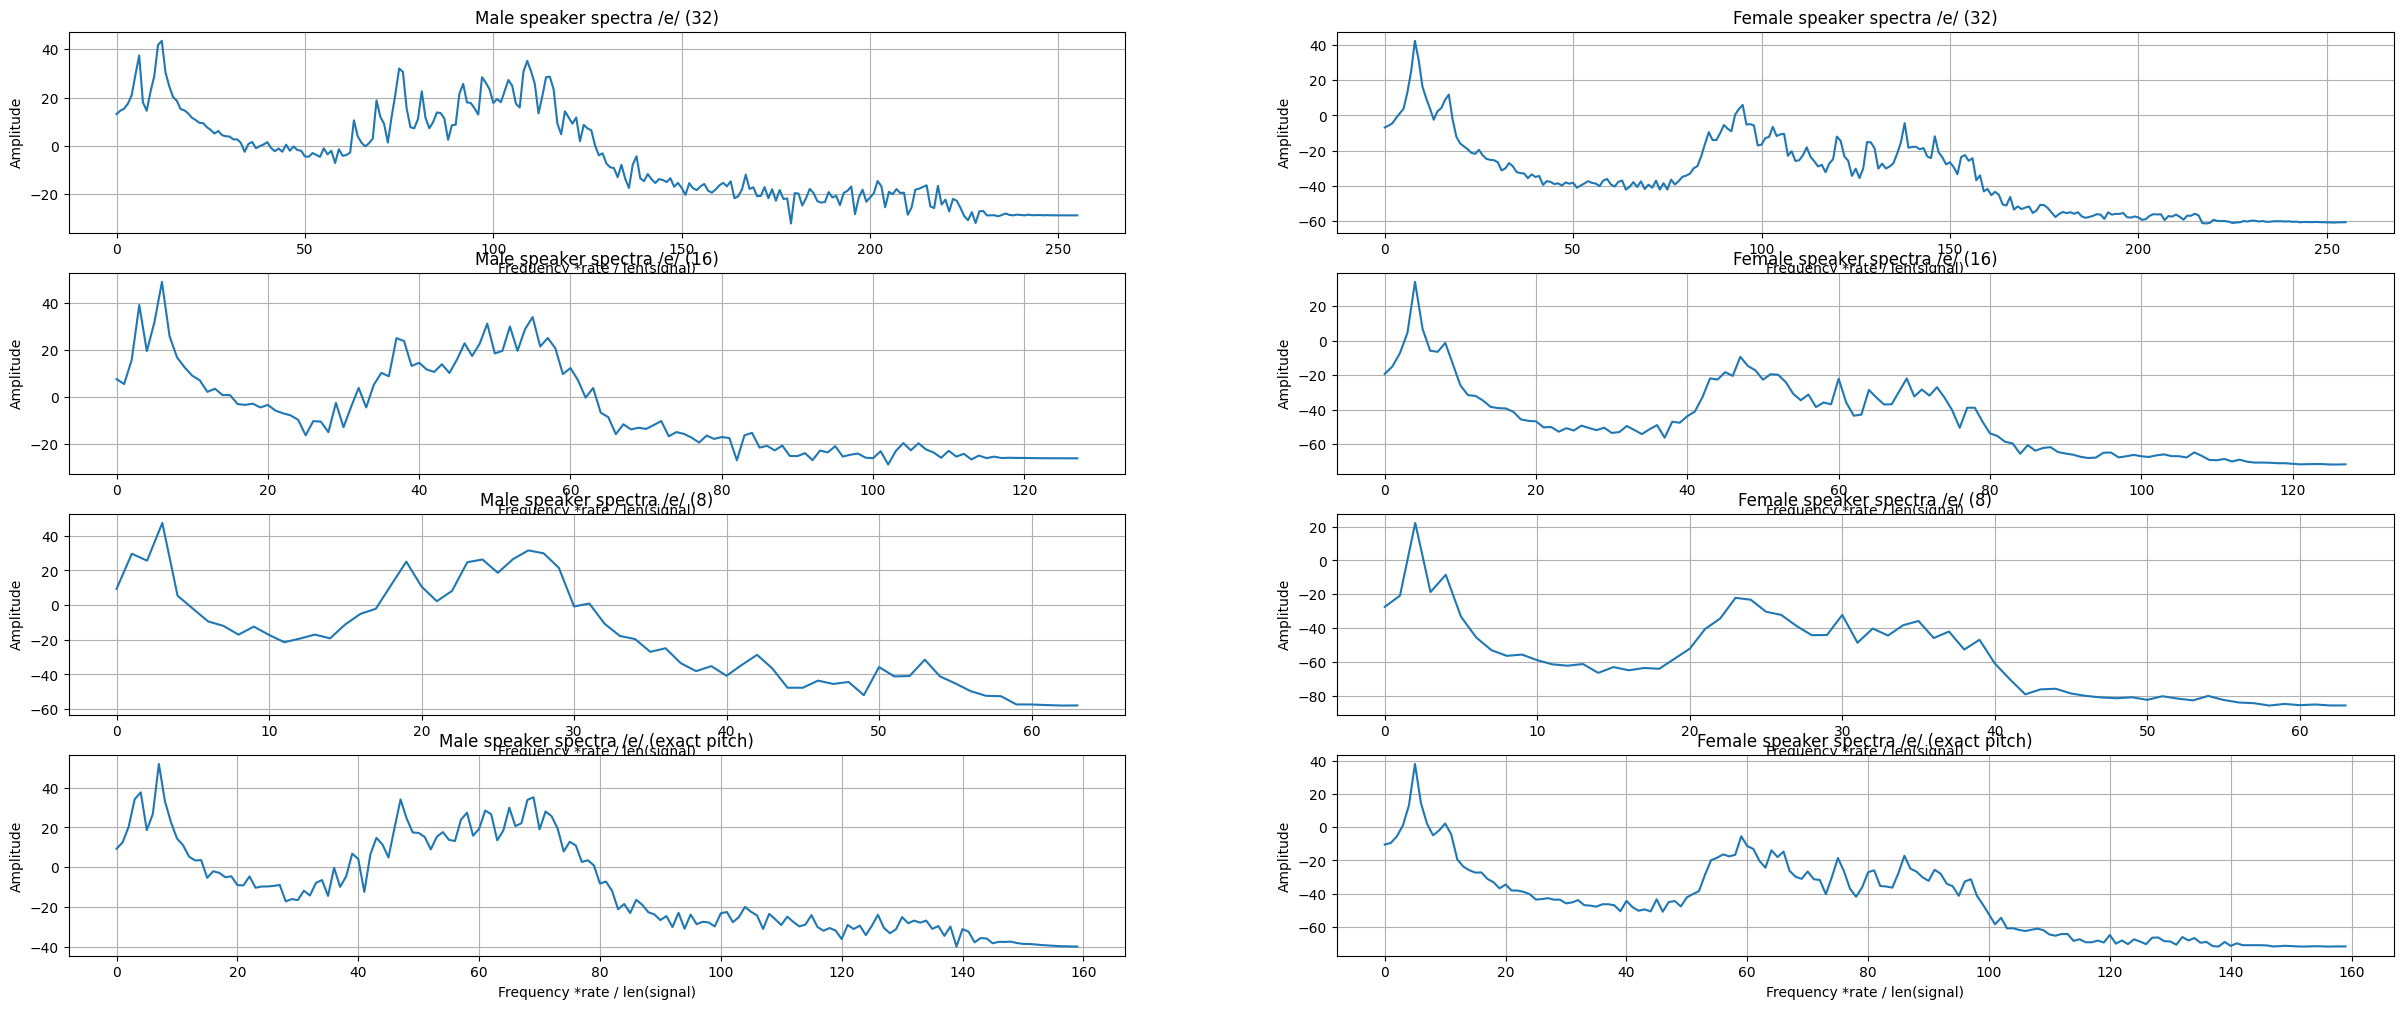

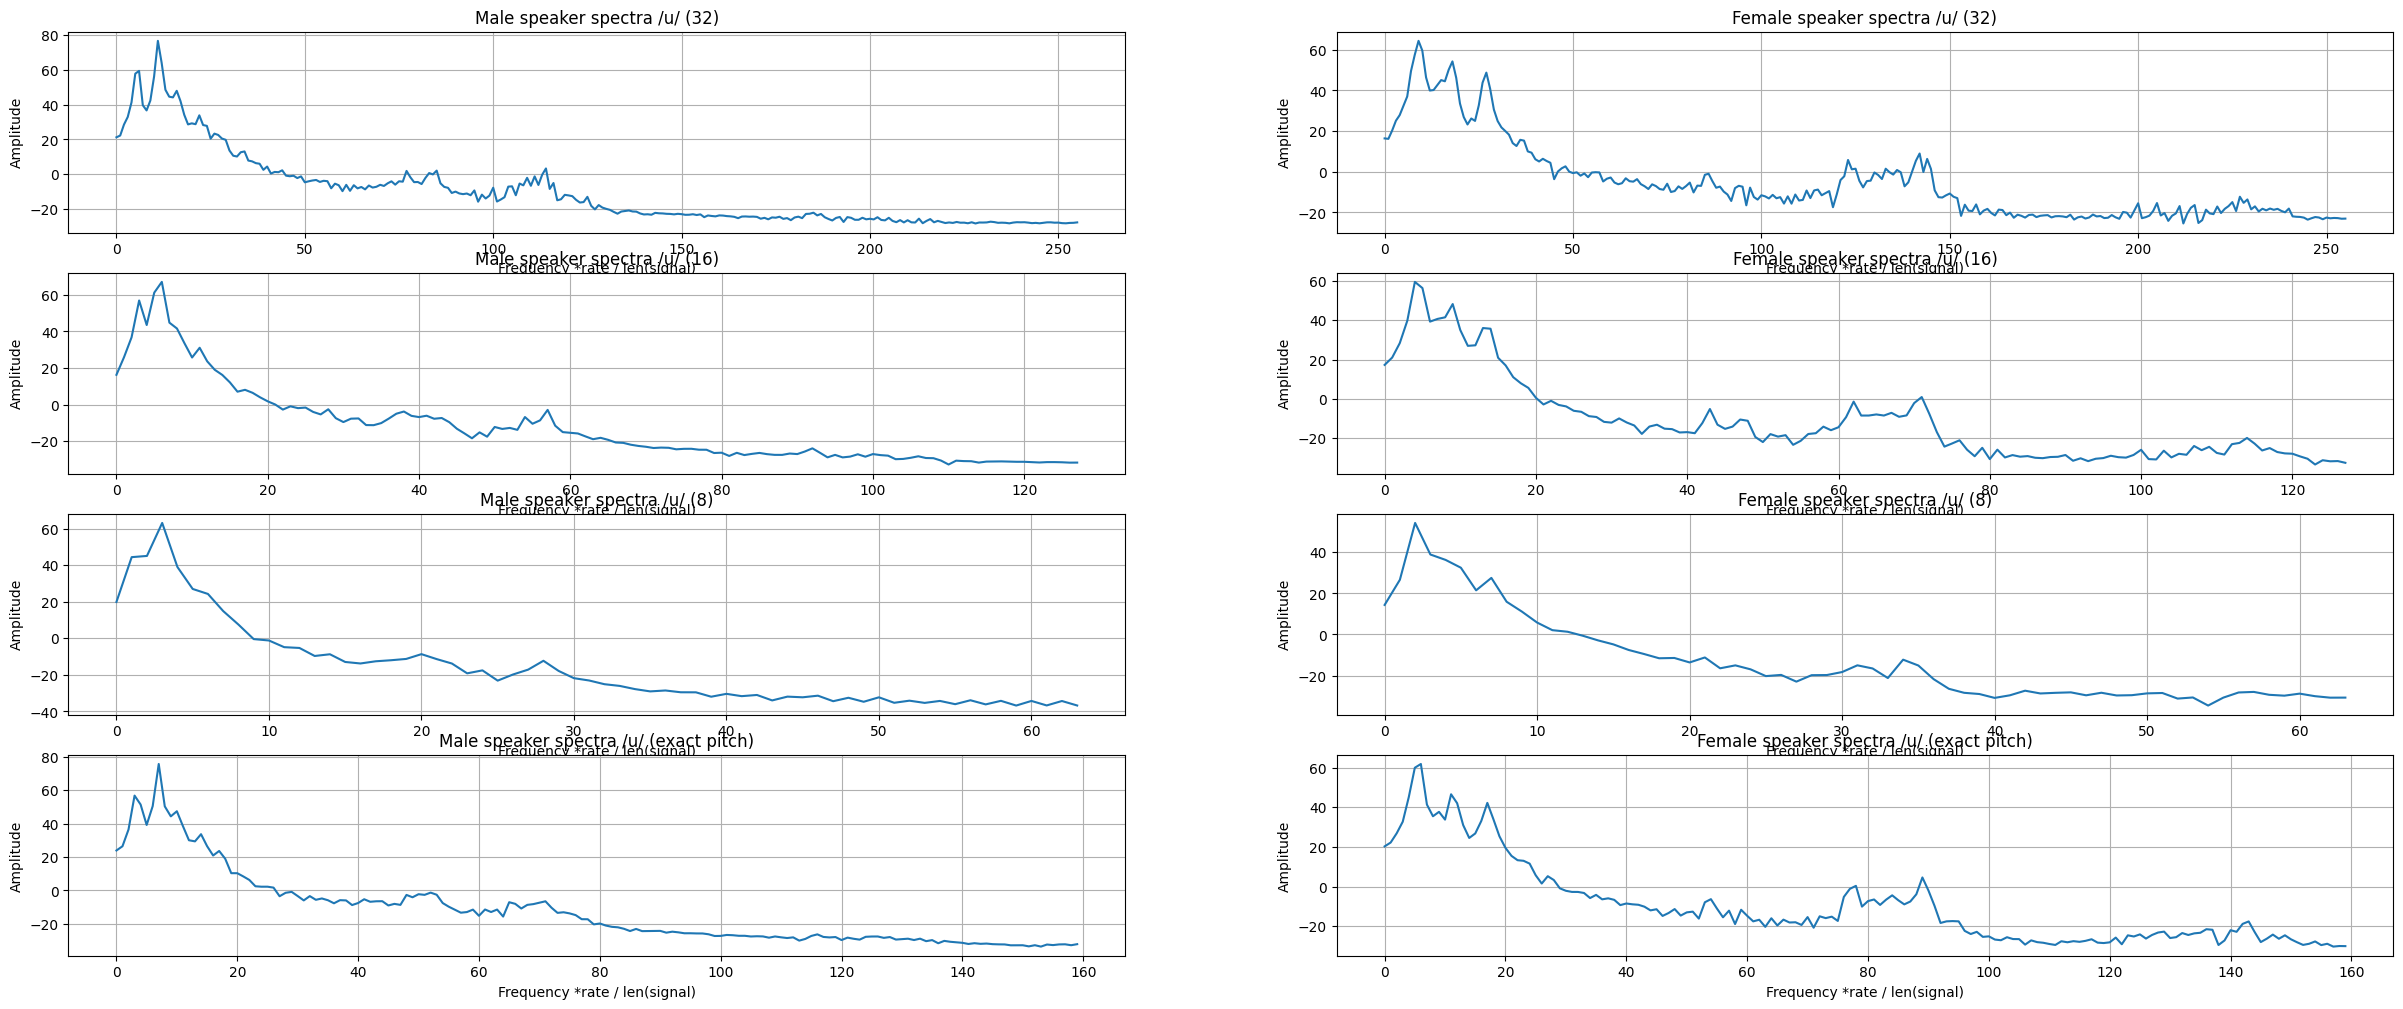

In [121]:
#Vary the window sizes and observe the things ( Skeleton code is written for vowel '/a/', you need to run the code for all the three vowels and included your observations in the report
exact_pitch = 20 # I will write it
window_sizes = [32, 16, 8, exact_pitch] #Compute the spectra for each frame of the vowel and average it to get the overall spectral of the correspoding vowel
from numpy.fft import fft, fftfreq

for vowel in ['a', 'e', 'u']:

  spectra_windows = [[], []]

  for window_size in window_sizes:


      #Get the signal for both male and female speakers
      #Load the recorded speech signal
      (recording,rate) = sf.read(f'male_{vowel}.wav')
      (f_recording,rate) = sf.read(f'female_{vowel}.wav')

      #Extract 1 dimensional signal using voiced tags of the frames
      sustained = Extract1D(recording, rate)
      f_sustained = Extract1D(f_recording, rate)

      frameSize = 0.001*window_size
      frameShift = 0.01
      Frames = FrameSig(sustained, rate, frameSize, frameShift)
      f_Frames = FrameSig(f_sustained, rate, frameSize, frameShift)

      result = np.zeros(int(frameSize*rate))
      f_result = np.zeros(int(frameSize*rate))

      #Compute the spectra of the signal
      #Compute the spectra of each window and average it
      for frame in Frames:

        if len(frame) != len(result):

          continue

        result += Spectra(frame)

      result /= len(Frames)
      spectra_windows[0].append(result)

      for frame in f_Frames:

        if len(frame) != len(f_result):

          continue

        f_result += Spectra(frame)

      f_result /= len(f_Frames)
      spectra_windows[1].append(f_result)

  fig, axes = plt.subplots(4, 2, figsize=(30, 12))

  axes[0][0].plot(spectra_windows[0][0][:len(spectra_windows[0][0])//2])
  axes[0][0].set_xlabel("Frequency *rate / len(signal)")
  axes[0][0].set_ylabel("Amplitude")
  axes[0][0].set_title(f"Male speaker spectra /{vowel}/ (32)")
  axes[0][0].grid()

  axes[1][0].plot(spectra_windows[0][1][:len(spectra_windows[0][1])//2])
  axes[1][0].set_xlabel("Frequency *rate / len(signal)")
  axes[1][0].set_ylabel("Amplitude")
  axes[1][0].set_title(f"Male speaker spectra /{vowel}/ (16)")
  axes[1][0].grid()

  axes[2][0].plot(spectra_windows[0][2][:len(spectra_windows[0][2])//2])
  axes[2][0].set_xlabel("Frequency *rate / len(signal)")
  axes[2][0].set_ylabel("Amplitude")
  axes[2][0].set_title(f"Male speaker spectra /{vowel}/ (8)")
  axes[2][0].grid()

  axes[3][0].plot(spectra_windows[0][3][:len(spectra_windows[0][3])//2])
  axes[3][0].set_xlabel("Frequency *rate / len(signal)")
  axes[3][0].set_ylabel("Amplitude")
  axes[3][0].set_title(f"Male speaker spectra /{vowel}/ (exact pitch)")
  axes[3][0].grid()

  axes[0][1].plot(spectra_windows[1][0][:len(spectra_windows[1][0])//2])
  axes[0][1].set_xlabel("Frequency *rate / len(signal)")
  axes[0][1].set_ylabel("Amplitude")
  axes[0][1].set_title(f"Female speaker spectra /{vowel}/ (32)")
  axes[0][1].grid()


  axes[1][1].plot(spectra_windows[1][1][:len(spectra_windows[1][1])//2])
  axes[1][1].set_xlabel("Frequency *rate / len(signal)")
  axes[1][1].set_ylabel("Amplitude")
  axes[1][1].set_title(f"Female speaker spectra /{vowel}/ (16)")
  axes[1][1].grid()


  axes[2][1].plot(spectra_windows[1][2][:len(spectra_windows[1][2])//2])
  axes[2][1].set_xlabel("Frequency *rate / len(signal)")
  axes[2][1].set_ylabel("Amplitude")
  axes[2][1].set_title(f"Female speaker spectra /{vowel}/ (8)")
  axes[2][1].grid()


  axes[3][1].plot(spectra_windows[1][3][:len(spectra_windows[1][3])//2])
  axes[3][1].set_xlabel("Frequency *rate / len(signal)")
  axes[3][1].set_ylabel("Amplitude")
  axes[3][1].set_title(f"Female speaker spectra /{vowel}/ (exact pitch)")
  axes[3][1].grid()


<dt> <h4>  1) Write down your observations on the time-domain characteristics of the vowels ('/a/', '/e/', '/u/') </h4> </dt>
<dd> <h4> a. /a/ is combination of 2 sinusoids at its formants F.</h4> </dd>
<dd> <h4> b. The vowel /e/ produces a waveform with a somewhat higher frequency content compared to /a/, as the vocal tract is more constricted. </h4> </dd>
<dd> <h4> c. The waveform for /u/ typically has a smooth, rounded appearance due to the low frequency content, as /u/ is produced with a very rounded, back tongue position and a constricted vocal tract. </h4> </dd>

<dt> <h4>  2) Write down your observations on the frequency-domain characteristics of the vowels ('/a/', '/e/', '/u/') </h4> </dt>
<dd> <h4> a. /a/: F1 occurs around 687.5 Hz for Males, 875 Hz for Females  </h4> </dd>
<dd> <h4> b. /e/: F1 occurs around 375 Hz for Males,  250 Hz for Females </h4> </dd>
<dd> <h4> c. /u/: F1 occurs around 312 Hz for Males, 280 Hz for Female  </h4> </dd>

<dt> <h4>  3) How can you estimate $F_{0}$ from magnitude spectrum </h4> </dt>
<dd> <h4> a. $F_{0}$ of male speaker voice that you analyzed - 130-140 Hz   </h4> </dd>
<dd> <h4> b. $F_{0}$ of female speaker voice that you analyzed - 230-240 Hz</h4> </dd>
<dd> <h4> c. Calculate spectral peaks , find difference between them and plot histograms of the differneces which gives an approximation of F0  </h4> </dd>


<h4> <center> <b>  Part2 :- Synthesis of vowels </center> </b> </h4>

<dt> <h4> <b> All-pole model of speech production: </b> This model represents the vocal tract as a series of resonant peaks (poles) to describe speech production. The all-pole model approximates the vocal tract's filter function with a polynomial that includes only poles and no zeros. The mathematical details of this all-pole model are as follows: </h4> </dt>



<ul type="circle" >
 <li> A spectral peak can be modeled as a complex conjugate pair of poles </li>
 <br/>
 <center> $p = re^{j\theta}$ </center>
 <center> $p* = re^{-j\theta}$ </center>
 <br/>
 <li> Vocal tract (VT) with multiple peaks can be approaximate as </li>
 <br/>
 <center> $V(z) = \frac{1}{1 + \sum\limits_{k=1}^{K} a_k z^{-k}}$ </center>
 <br/>
 <li> Z-domain representation of speech signal S(Z) is multiplication of Z-domain representations of vocal tract (Filter)  and impulse (Input)  </li>
 <br/>
 <center> $S(z) = V(z)G(z) =\frac{G(z)}{1 + \sum\limits_{k=1}^{K} a_k z^{-k}}$ </center>
  <center> $S(z)\left(1 + \sum\limits_{k=1}^{K}a_k z^{-k}\right) = G(z)$ </center>
 <center> $S(z) = - \sum\limits_{k=1}^{K} a_k S(z)z^{-k} + G(z)$ </center>
 <li> Applying inverse z-transform on both sides, </li>
 <center> $s[n] = - \sum\limits_{k=1}^{K} a_k s[n-k] + g[n]$ </center>
 <li> Since we do not have access to $g[n]$, we can only get an estimate of $s[n]$, given by </li>

 <center> $\hat{s}[n] = -\sum\limits_{k=1}^{K} a_k s[n-k]$ </center>
<li> That is, the current sample of $s[n]$ is predicted as a linear weighted combination of past $K$ samples. The prediction coefficients $a_k$ are estimated by minimizing leat square square errors </li>  
 <center> $J(\textbf{a}) = E[|e[n]|^{2}]$ </center>
where $e[n]=s[n]-\hat{s}[n]$. The linear prediction (LP) coefficients can be estimated by equating partial derivative of $J(\mathbf{a})$ w.r.t. each filter coefficient $a_k$ to zero i.e, $\frac{\partial J(\textbf{a}) }{\partial a_k}$  = 0, for $k=1,2,\cdots K$. Show that the Lp coeffcients thus obtained can be expressed as
<center> $\textbf{a}$ = $\textbf{R}_{ss}^{-1} \textbf{r}_{ss}[1]$ </center>
where $\mathbf{R}_{ss}$ is the autocorrleation matrix of speech frame and $\mathbf{r}_{ss}[1]$ is tha autocorrelation vector from the first lag onwards.
</li>
<li> Once the LP coefficients are estimated, the excitation signal $(g[n])$ can be obtained by filtering the speech signal $s[n]$ though inverse filter $\frac{1}{V(z)}$ </li>
</ul>

<dt> <h4>  <b> Programming Questions: </b> </h4> </dt>

<dt> <h4> 1) Write a function to estimate the linear prediction (LP) coefficients $(\textbf{a})$ from the speech signal </h4> </dt>
<dd> <h4> - Implement the following equation: $\textbf{a}$ = $\textbf{R}_{ss}^{-1} \textbf{r}_{ss}[1]$   </h4> </dd>
<dd> <h4> - You can compare your solution with the output from the built-in function pysptk.lpc(). </h4> </dd>


<dt> <h4> 2) Plot the unit sample response of the vocal tract using the estimated LP coefficients </h4> </dt>
<dd> <h4> - You may use scipy library for it. </h4> </dd>

<dt> <h4> 3) Plot the frequency response (LP spectrum) of the vocal tract using the estimated LP coefficients. </h4> </dt>
<dd> <h4> - You may use scipy library for it. </h4> </dd>

<dt> <h4> 4) Inverse filter the speech signal with the estimated vocal tract filter to obtain an estimate of the excitation signal (LP residual). Plot the residual signal and identify the time points of glottal closure.  </h4> </dt>
<dd> <h4> - You may use scipy library for it. </h4> </dd>


<dt> <h4> 5) Manually determine the formant frequencies of the sustained vowels /a/, /i/, and /u/ from their LP spectra.  </h4> </dt>

<dt> <h4> 6) Synthesize the speech signal by exciting the estimated vocal tract system $(V(z))$ for the sustained vowels /a/, /i/, and /u/ with a sequence of impulses at different fundamental periods $(T_{0})$. Choose $(T_{0})$ to achieve fundamental frequencies $(F_{0})$ of 100 Hz, 200 Hz, and 300 Hz. Listen to the synthesized vowels and report your observations. </h4> </dt>





In [46]:
#Use the above estimated a_k's to find the vocal tract responce.
#Speech singnal is known and vocal tract is known, now you use these two things to get the excitation signal
#Synthesize the signal using estimated vocal tract (Filter) and excitation signal (Input)
#Observe the difference between synthesized and original signals and write your observations in the report

#Estimate the vocal tract parameters i.e a_k's
def estimate_a(frame, p):

  Rss = np.zeros((p, p))

  for i in range(p):

    for j in range(p):

      Rss[i][j] = rxx(frame, abs(i-j))

  rss = np.zeros(p+1)

  for i in range(p+1):

    rss[i] = rxx(frame, i)

  return -np.linalg.inv(Rss) @ rss[1:]




#Estimate the excitation signal

def estimate_excitation_signal(frame, p):


  a = estimate_a(frame, p)

  excitation_estimate = np.zeros(len(frame))

  for i in range(len(frame)):

    excitation_estimate[i] = frame[i]

    for j in range(p):

      if i-j >= 0:

        excitation_estimate[i] += a[j]*frame[i-j]

  return excitation_estimate


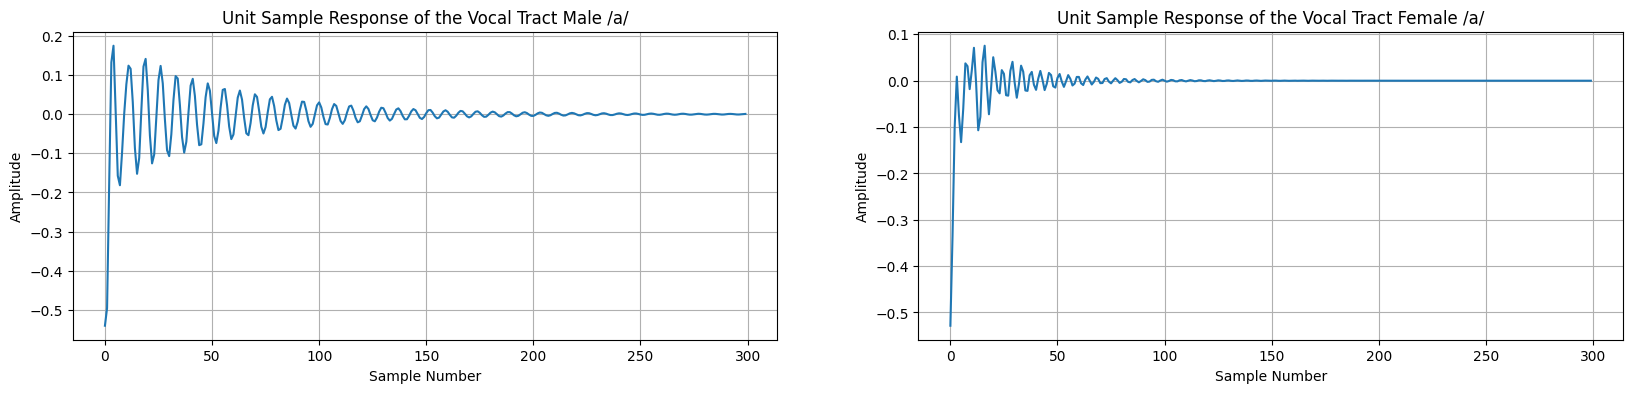

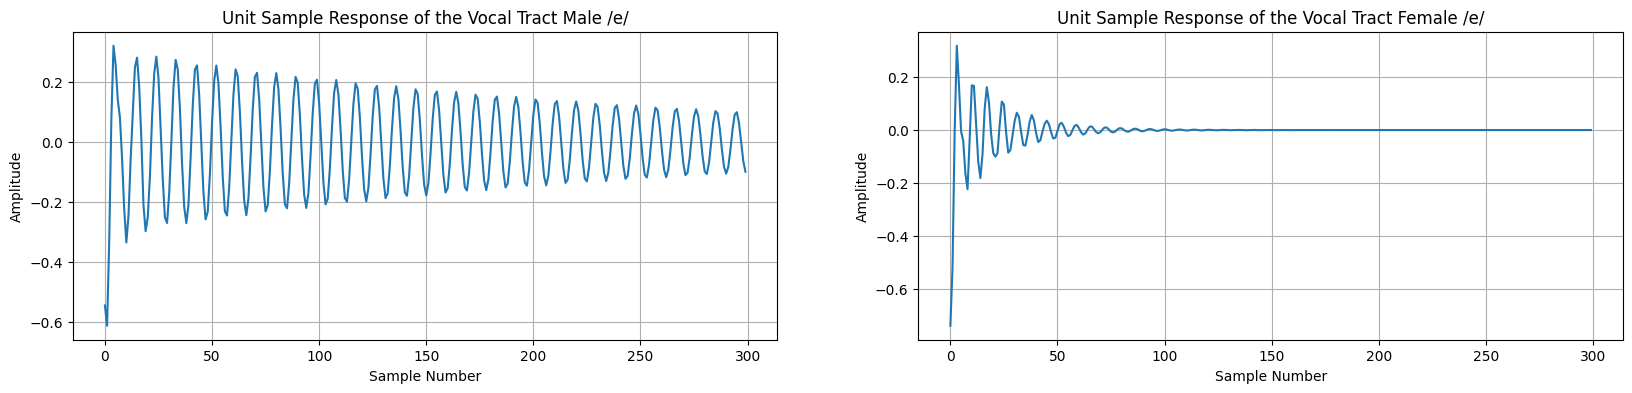

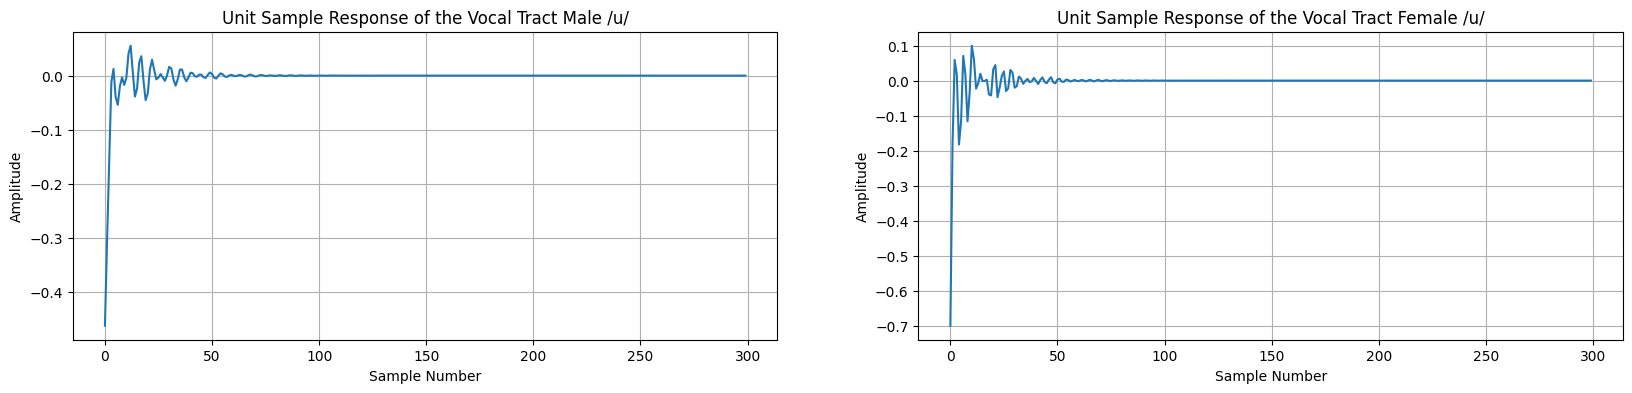

In [47]:
for vowel in ['a', 'e', 'u']:

  recording, rate = sf.read(f'male_{vowel}.wav')
  sustained = Extract1D(recording, rate)
  frameSize = 0.025
  frameShift = 0.01
  Frames = FrameSig(sustained, rate, frameSize, frameShift)

  lpc_coeffs = estimate_a(Frames[2], 25)
  n_samples = 500  # Number of samples to plot
  impulse = np.zeros(n_samples)
  impulse[0] = 1  # Set the first sample to 1

  # Compute the unit sample response (impulse response)
  response = scipy.signal.lfilter([1], lpc_coeffs, impulse)

  f_recording, f_rate = sf.read(f'female_{vowel}.wav')
  f_sustained = Extract1D(f_recording, f_rate)
  f_Frames = FrameSig(f_sustained, f_rate, frameSize, frameShift)

  f_lpc_coeffs = estimate_a(f_Frames[2], 25)
  f_response = scipy.signal.lfilter([1], f_lpc_coeffs, impulse)

  fig, axes = plt.subplots(1, 2, figsize=(20, 4))
  # Plot the impulse response
  axes[0].plot(response[:300])
  axes[0].set_title(f'Unit Sample Response of the Vocal Tract Male /{vowel}/')
  axes[0].set_xlabel('Sample Number')
  axes[0].set_ylabel('Amplitude')
  axes[0].grid()

  axes[1].plot(f_response[:300])
  axes[1].set_title(f'Unit Sample Response of the Vocal Tract Female /{vowel}/')
  axes[1].set_xlabel('Sample Number')
  axes[1].set_ylabel('Amplitude')
  axes[1].grid()
  plt.show()

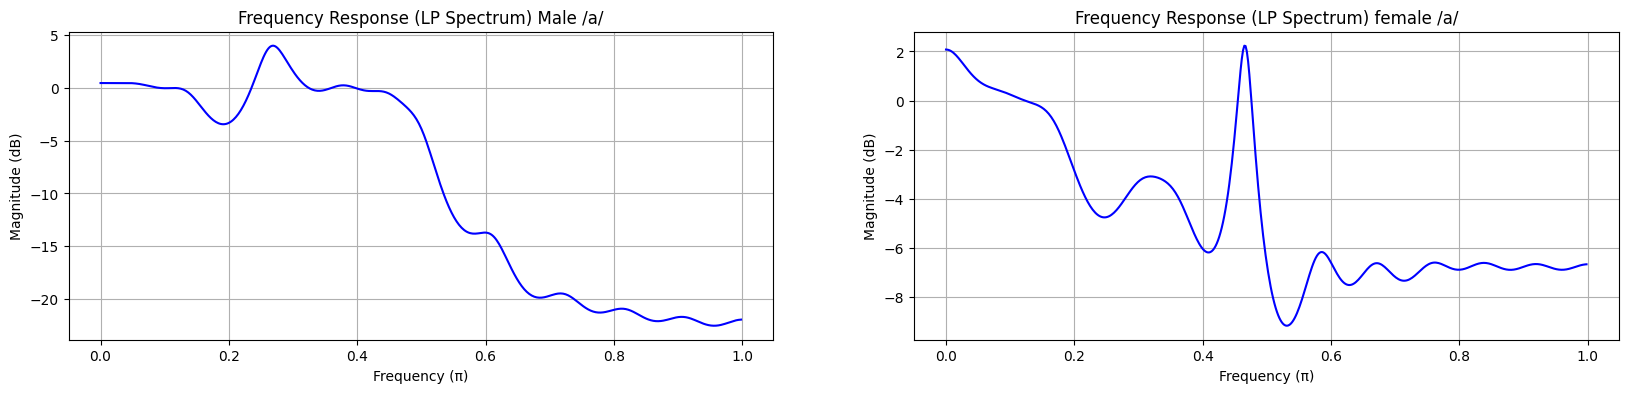

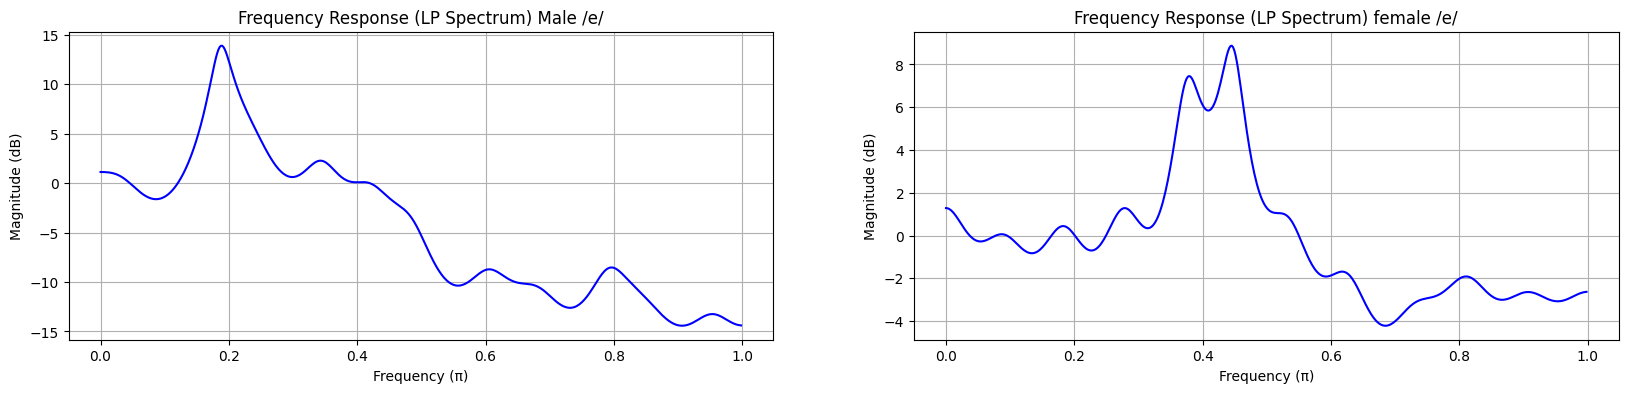

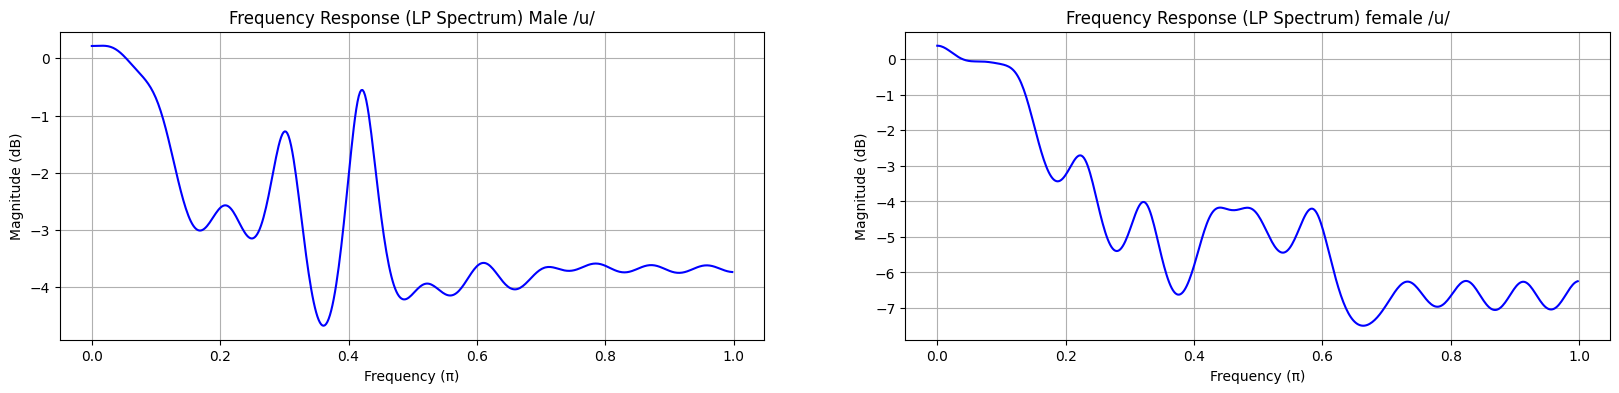

In [48]:
for vowel in ['a', 'e', 'u']:

  recording, rate = sf.read(f'male_{vowel}.wav')
  sustained = Extract1D(recording, rate)
  frameSize = 0.025
  frameShift = 0.01
  Frames = FrameSig(sustained, rate, frameSize, frameShift)

  f_recording, f_rate = sf.read(f'female_{vowel}.wav')
  f_sustained = Extract1D(f_recording, f_rate)
  f_Frames = FrameSig(f_sustained, f_rate, frameSize, frameShift)

  f_lpc_coeffs = estimate_a(f_Frames[0], 25)
  lpc_coeffs = estimate_a(Frames[0], 25)

  # Calculate the frequency response
  w, h = scipy.signal.freqz(b=[1], a=lpc_coeffs)
  f_w, f_h = scipy.signal.freqz(b=[1], a=f_lpc_coeffs)
  # Plot the magnitude spectrum
  fig, axes = plt.subplots(1, 2, figsize=(20, 4))

  axes[0].plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
  axes[0].grid()
  axes[0].set_xlabel('Frequency (π)')
  axes[0].set_ylabel('Magnitude (dB)')
  axes[0].set_title(f'Frequency Response (LP Spectrum) Male /{vowel}/')

  axes[1].plot(f_w / np.pi, 20 * np.log10(abs(f_h)), 'b')
  axes[1].grid()
  axes[1].set_xlabel('Frequency (π)')
  axes[1].set_ylabel('Magnitude (dB)')
  axes[1].set_title(f'Frequency Response (LP Spectrum) female /{vowel}/')
  plt.show()

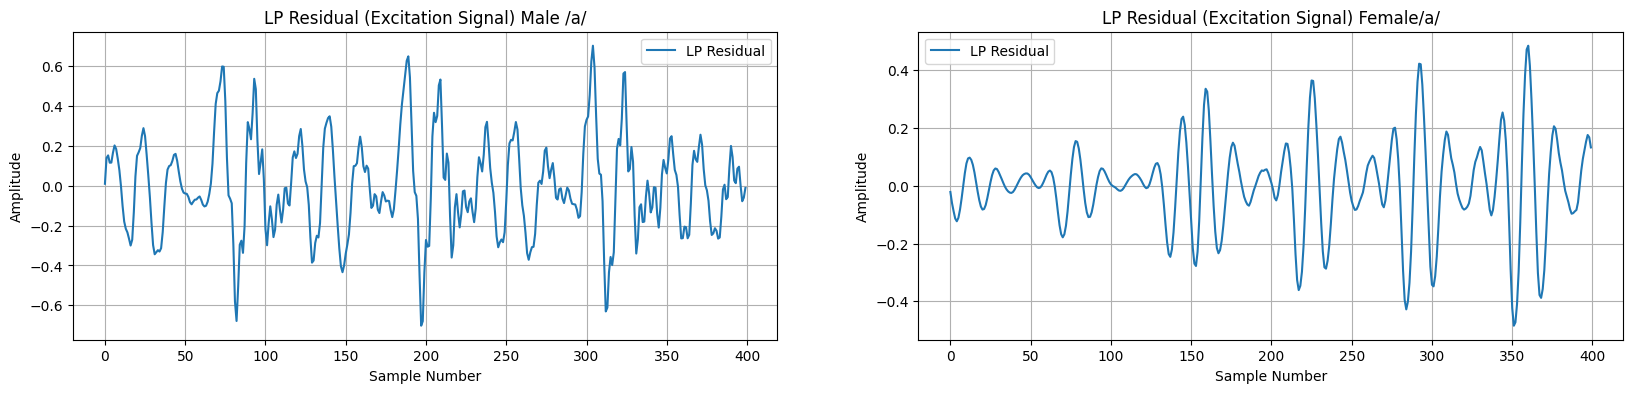

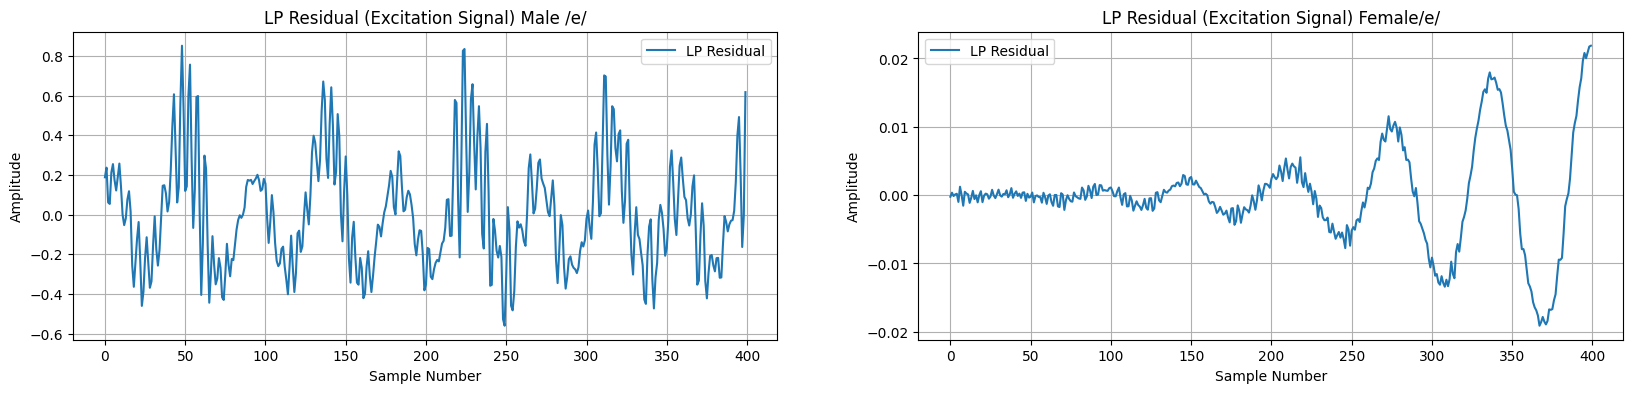

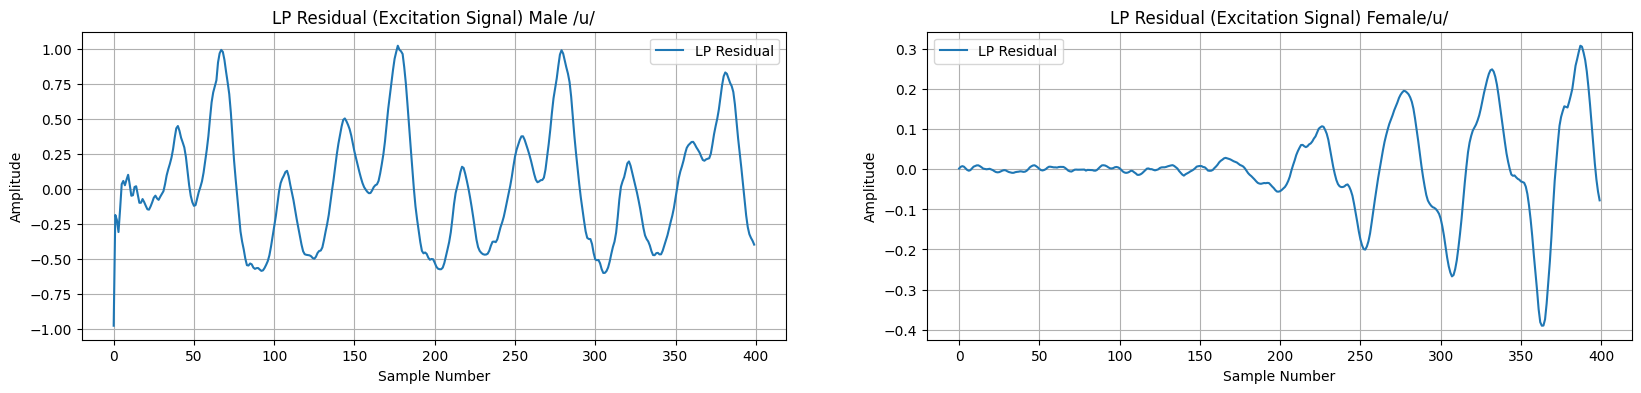

In [49]:
for vowel in ['a', 'e', 'u']:

  recording, rate = sf.read(f'male_{vowel}.wav')
  sustained = Extract1D(recording, rate)
  frameSize = 0.025
  frameShift = 0.01
  Frames = FrameSig(sustained, rate, frameSize, frameShift)

  f_recording, f_rate = sf.read(f'female_{vowel}.wav')
  f_sustained = Extract1D(f_recording, f_rate)
  f_Frames = FrameSig(f_sustained, f_rate, frameSize, frameShift)

  lpc_coeffs = estimate_a(Frames[2], 25)
  f_lpc_coeffs = estimate_a(f_Frames[2], 25)

  #Estimate the excitation signal
  residual_signal = scipy.signal.lfilter(lpc_coeffs, [1], Frames[0])
  f_residual_signal = scipy.signal.lfilter(f_lpc_coeffs, [1], f_Frames[0])

  # Plot the residual signal
  fig, axes = plt.subplots(1, 2, figsize=(20, 4))

  axes[0].plot(residual_signal, label='LP Residual')
  axes[0].set_title(f'LP Residual (Excitation Signal) Male /{vowel}/')
  axes[0].set_xlabel('Sample Number')
  axes[0].set_ylabel('Amplitude')
  axes[0].grid()
  axes[0].legend()

  axes[1].plot(f_residual_signal, label='LP Residual')
  axes[1].set_title(f'LP Residual (Excitation Signal) Female/{vowel}/')
  axes[1].set_xlabel('Sample Number')
  axes[1].set_ylabel('Amplitude')
  axes[1].grid()
  axes[1].legend()
  plt.show()

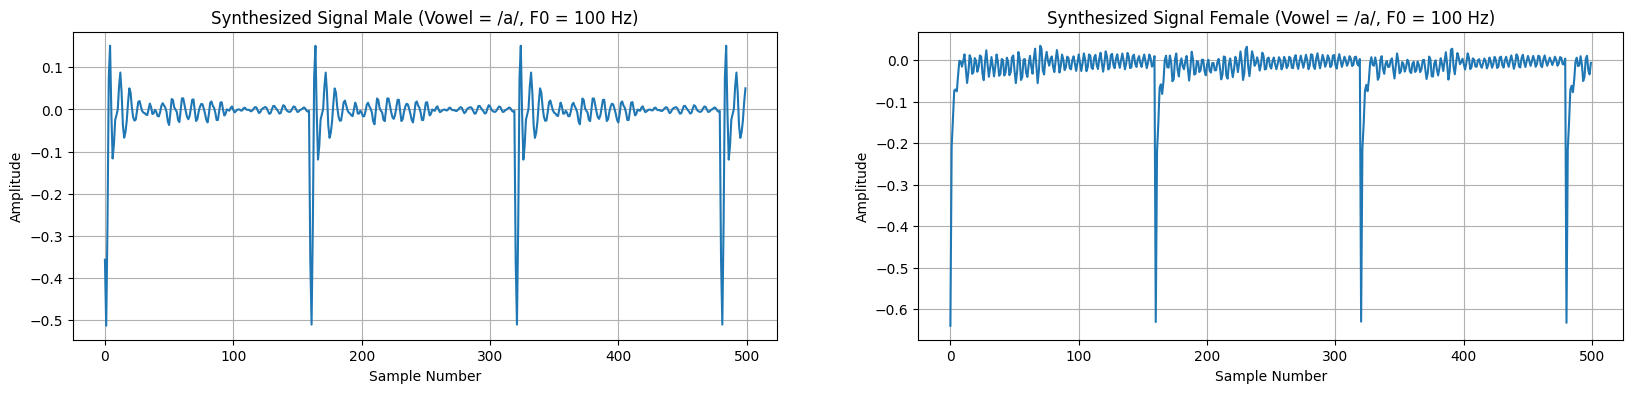

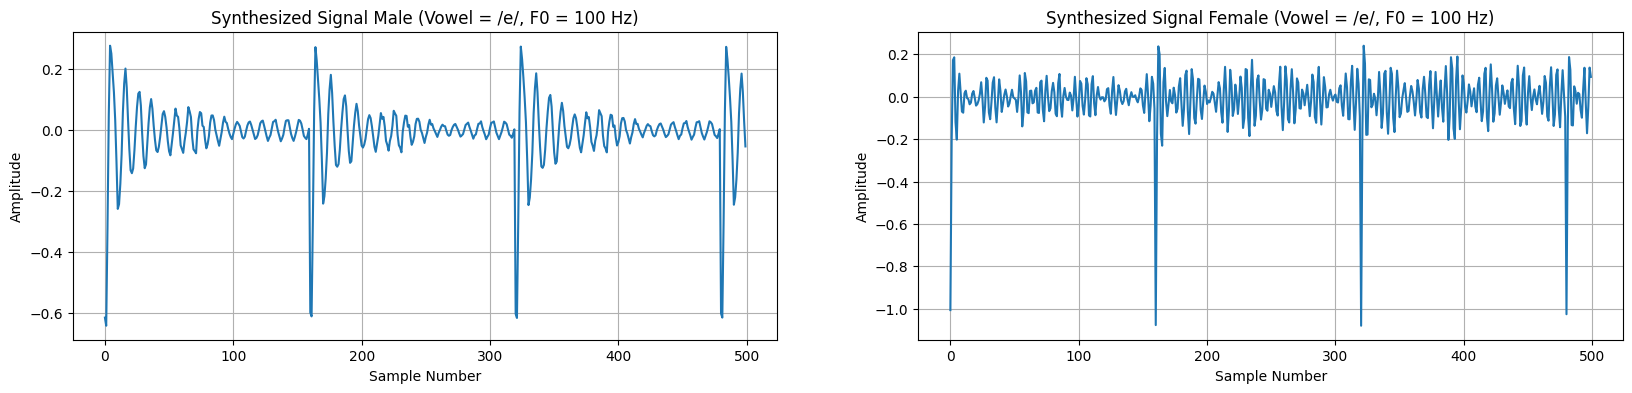

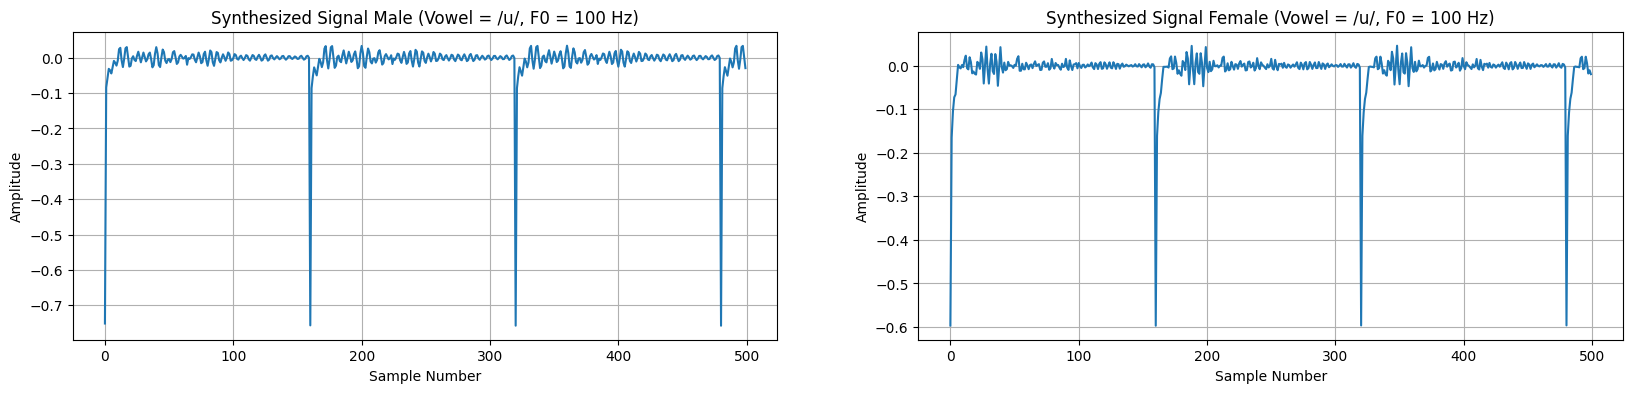

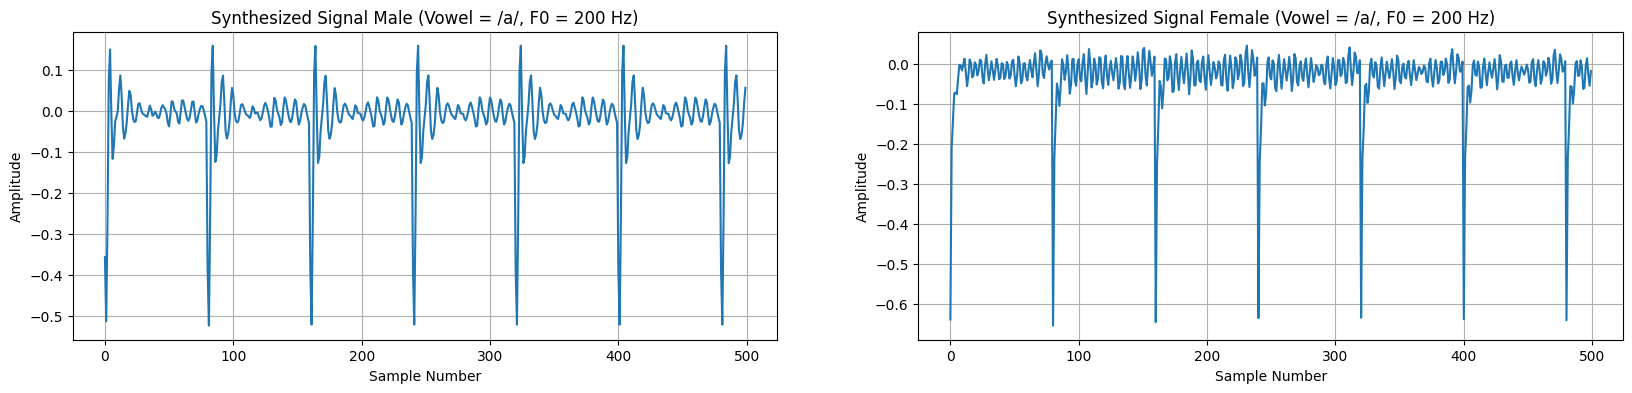

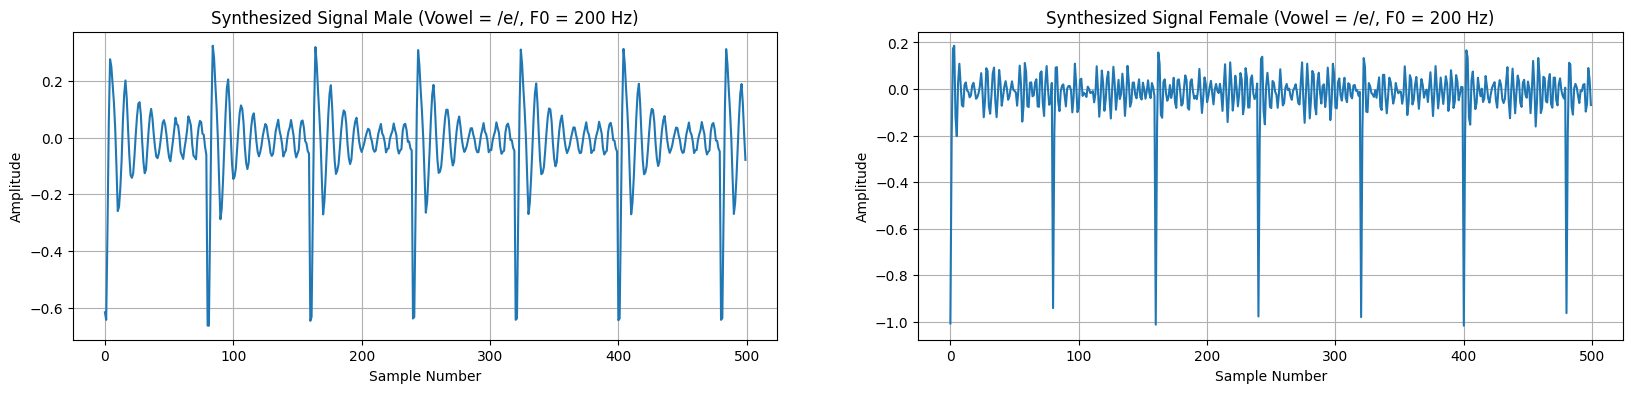

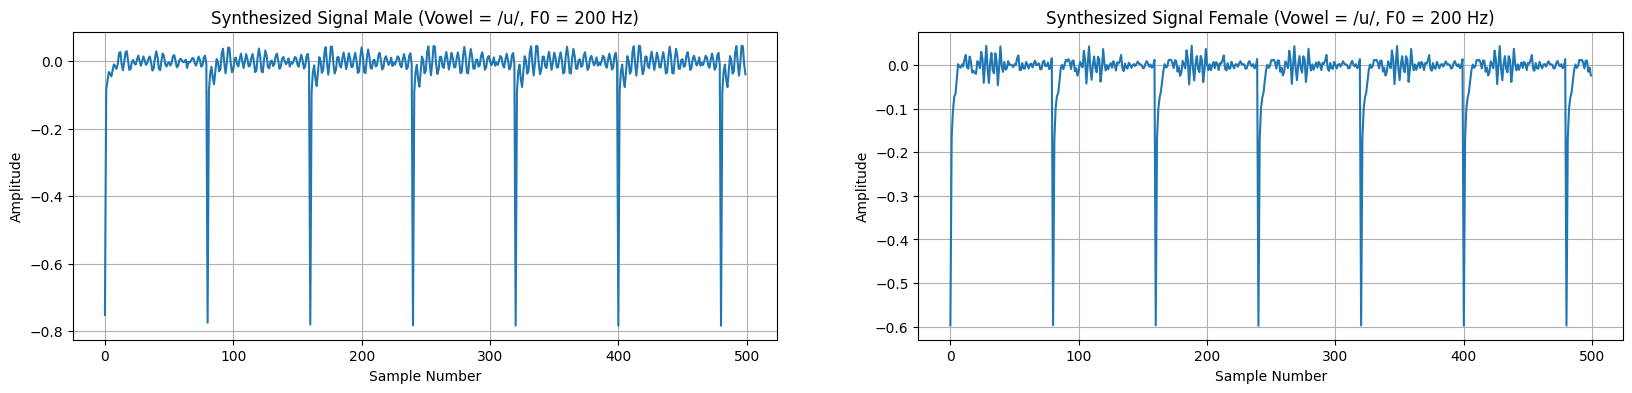

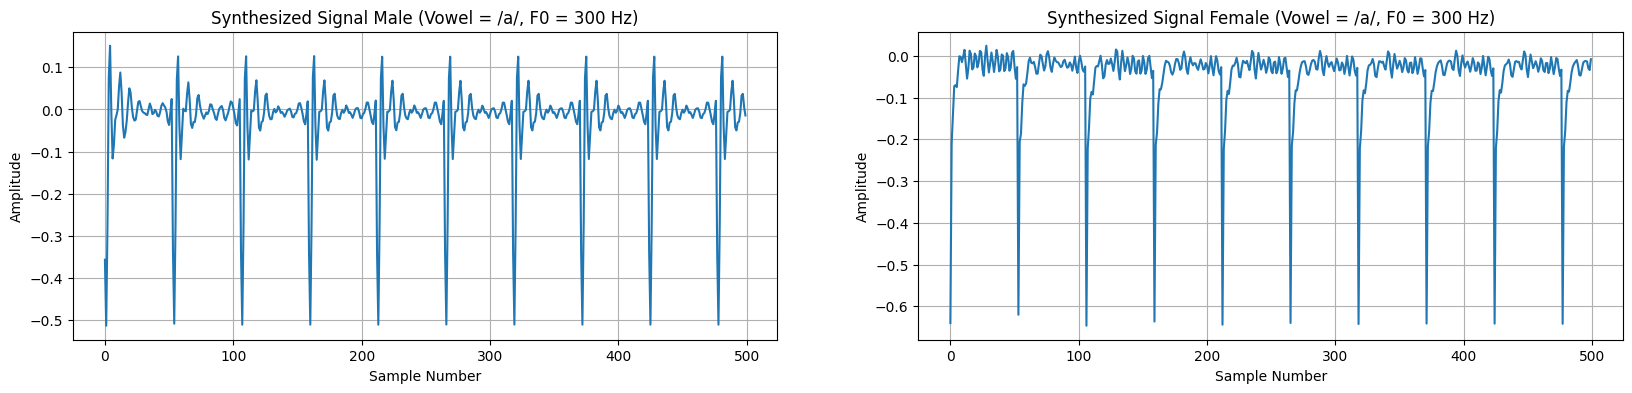

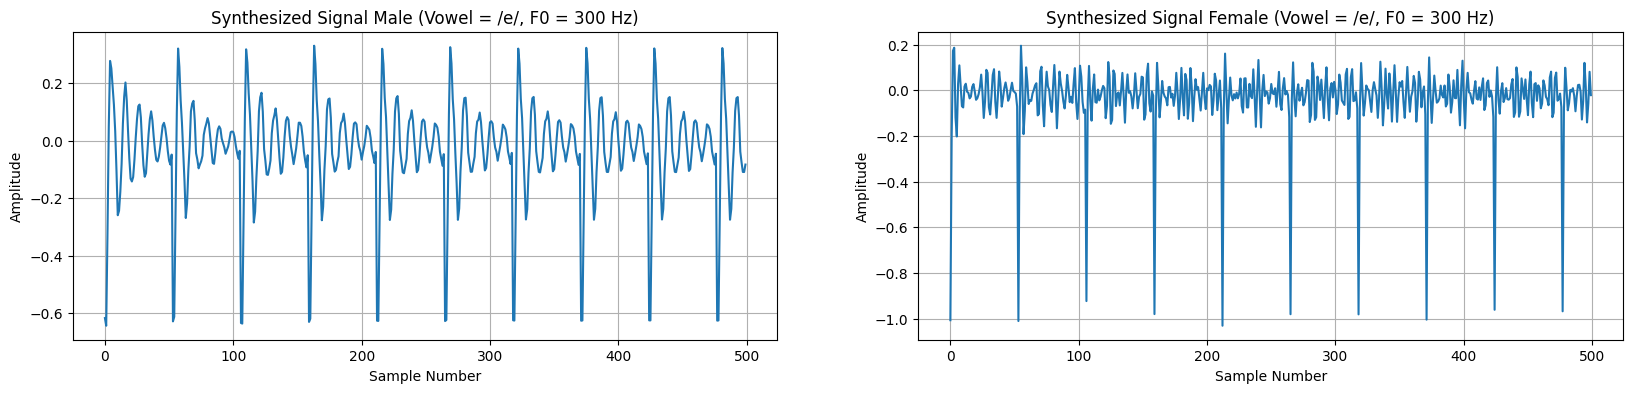

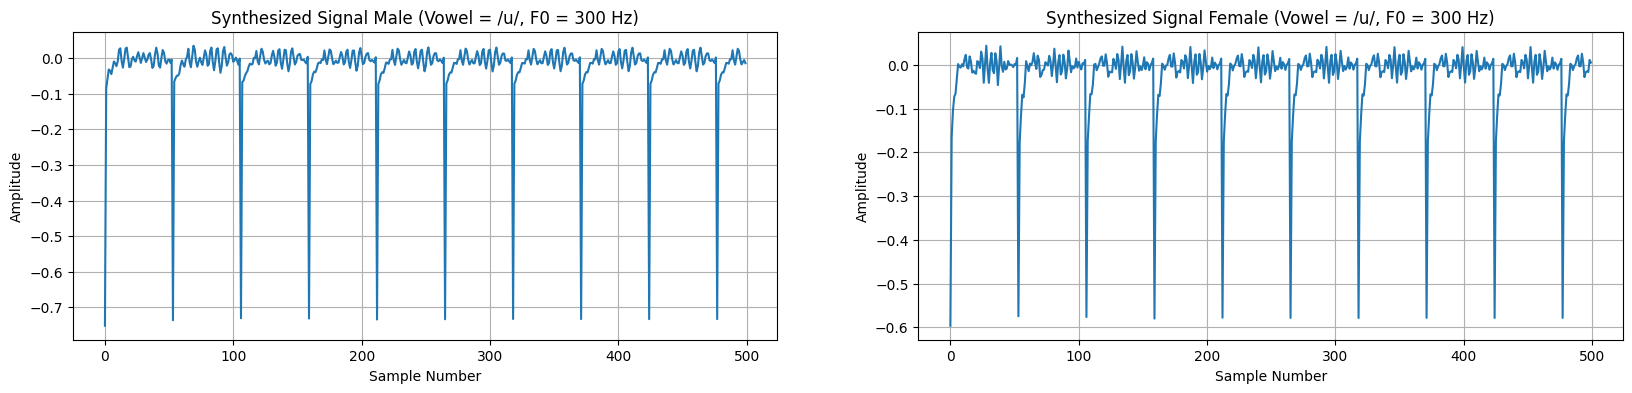

In [50]:
#Synthesize the speech signal using estimated vocal tract parameters and excitation signal
F0s = [100, 200, 300]  # Fundamental frequencies in Hz

for F0 in F0s:

  for vowel in ['a', 'e', 'u']:

    # Load the male vowel signal
    recording, rate = sf.read(f'male_{vowel}.wav')

    sustained = Extract1D(recording, rate)
    frameSize = 0.025
    frameShift = 0.01
    Frames = FrameSig(sustained, rate, frameSize, frameShift)

    f_recording, f_rate = sf.read(f'female_{vowel}.wav')
    f_sustained = Extract1D(f_recording, f_rate)
    f_Frames = FrameSig(f_sustained, f_rate, frameSize, frameShift)

    T0 = int(rate/F0)

    impulse_train = np.zeros(int(rate)*2)
    impulse_train[::T0] = 1

    lp_coeffs = estimate_a(Frames[0], 100)
    f_lp_coeffs = estimate_a(f_Frames[0], 100)

    synthesized_signal = scipy.signal.lfilter([1], lp_coeffs, impulse_train)
    f_synthesized_signal = scipy.signal.lfilter([1], f_lp_coeffs , impulse_train)

    sf.write(f'male_{vowel}_{F0}.wav', synthesized_signal, 16000)
    sf.write(f'female_{vowel}_{F0}.wav', f_synthesized_signal, 16000)

    # Plot the synthesized signal
    fig, axes = plt.subplots(1, 2, figsize=(20, 4))
    axes[0].plot(synthesized_signal[:500])
    axes[0].set_title(f'Synthesized Signal Male (Vowel = /{vowel}/, F0 = {F0} Hz)')
    axes[0].set_xlabel('Sample Number')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid()

    axes[1].plot(f_synthesized_signal[:500])
    axes[1].set_title(f'Synthesized Signal Female (Vowel = /{vowel}/, F0 = {F0} Hz)')
    axes[1].set_xlabel('Sample Number')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid()
    plt.show()
#Plot the spectra of original and synthesized signal and write your obervations in the report

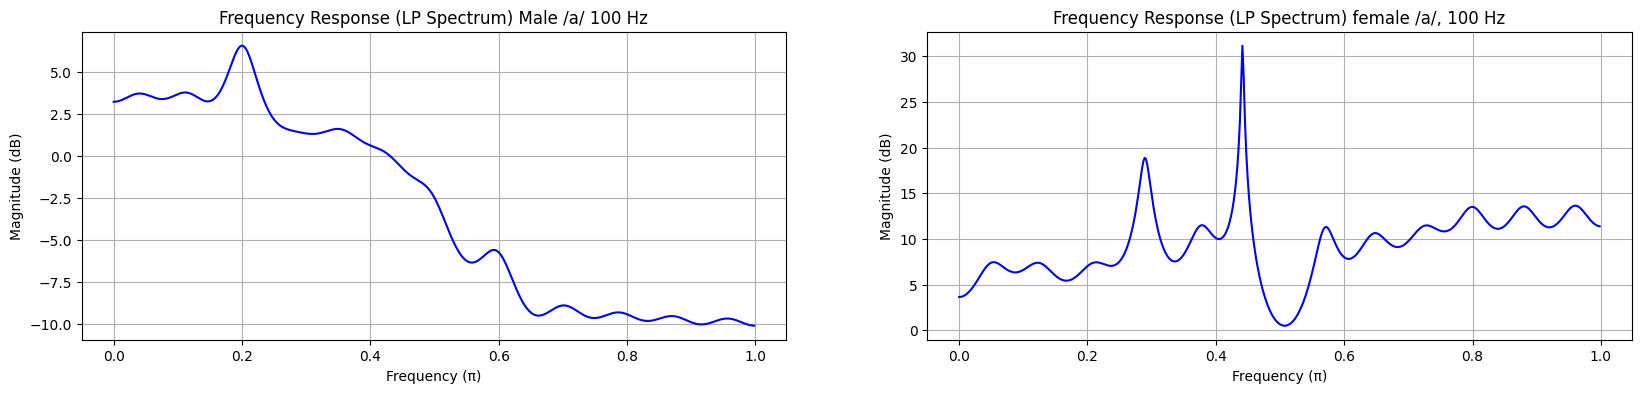

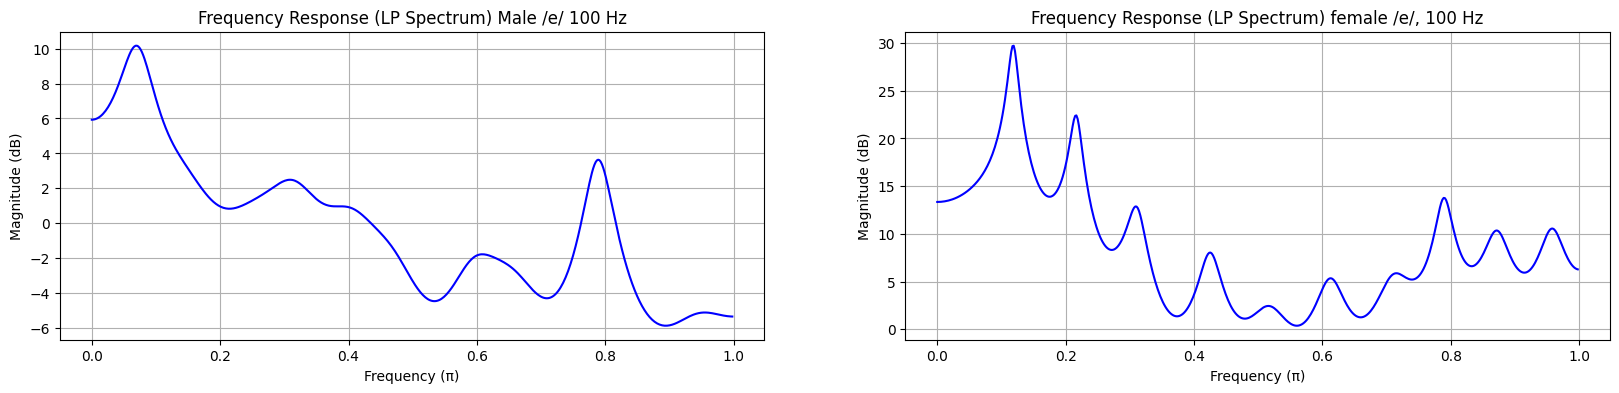

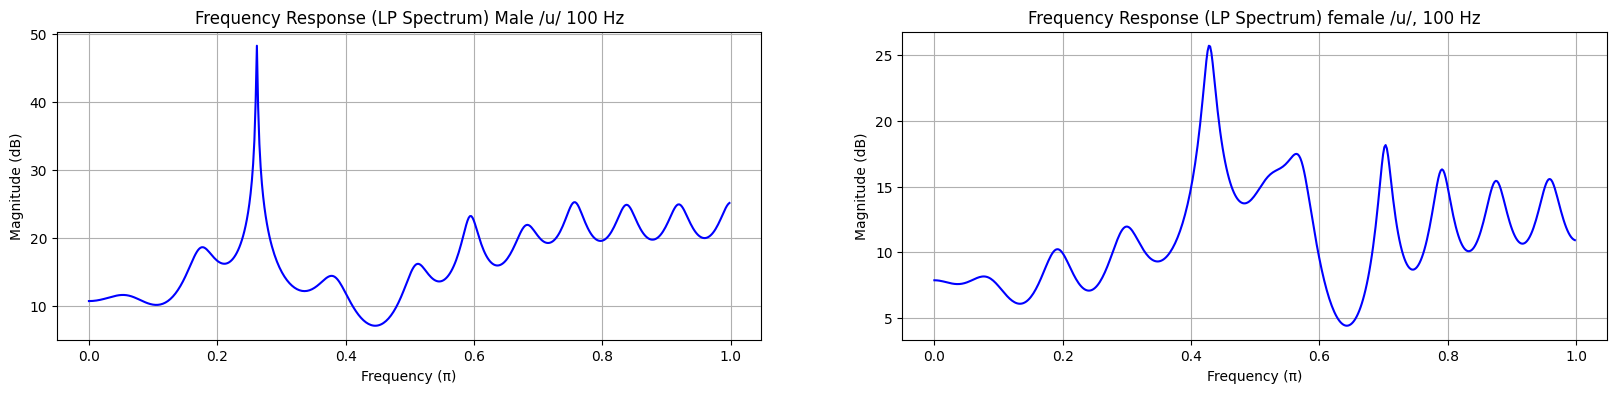

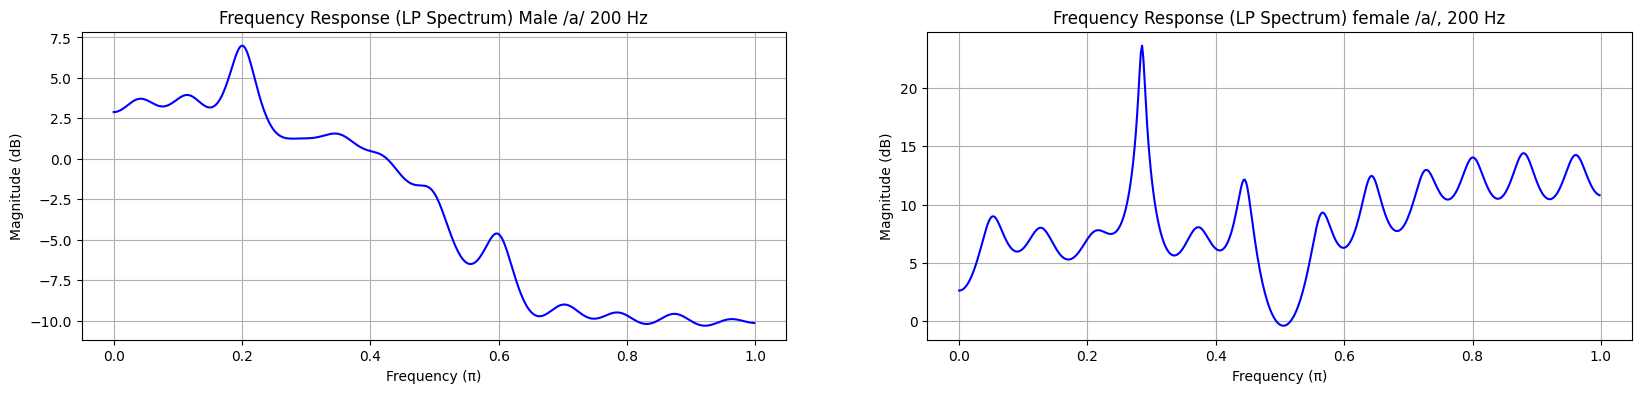

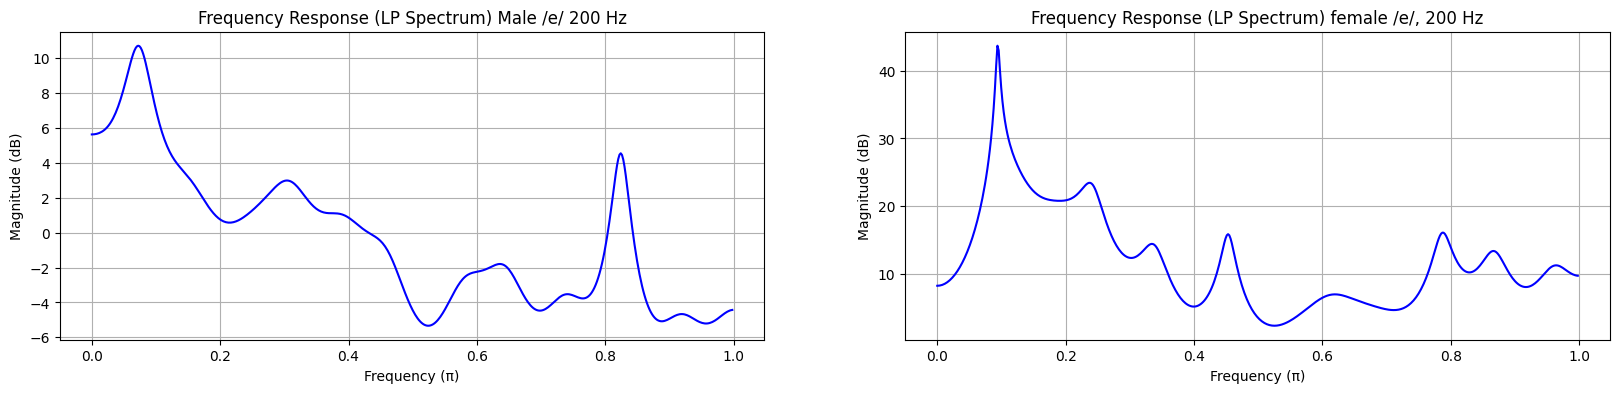

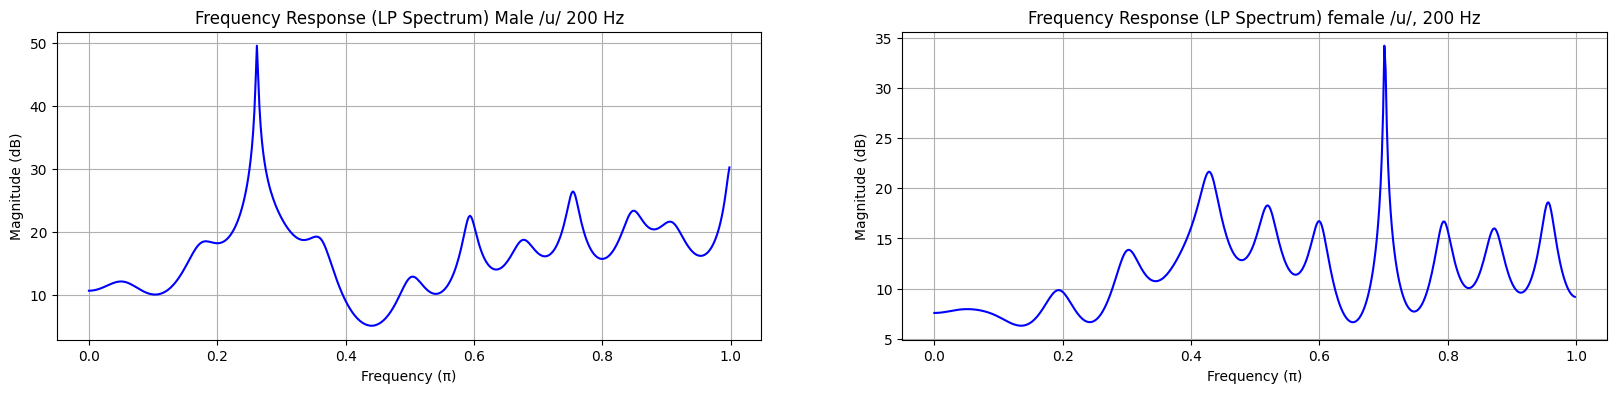

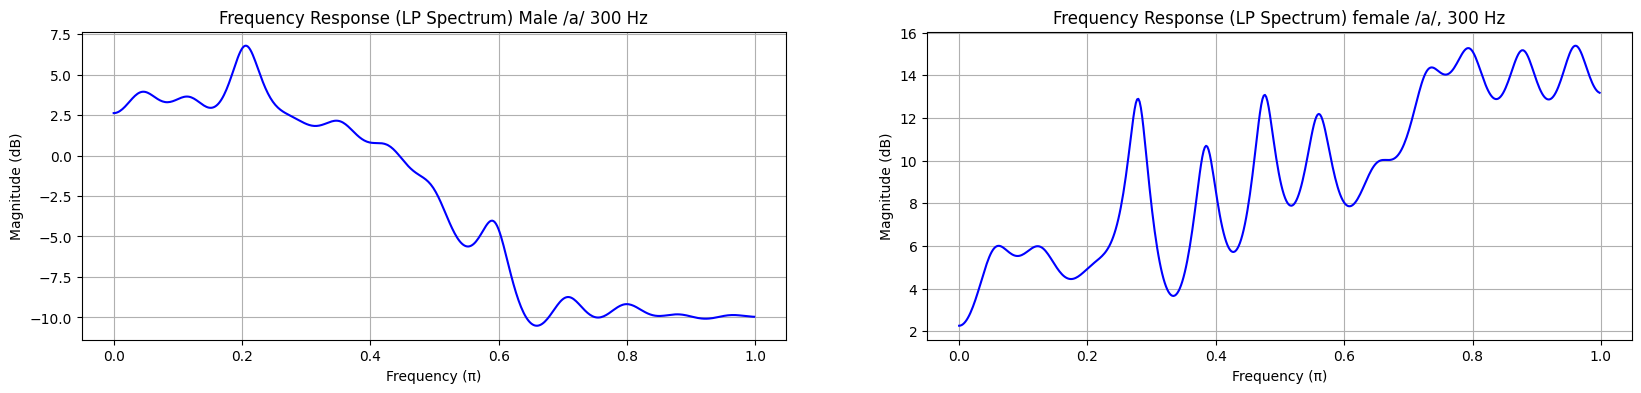

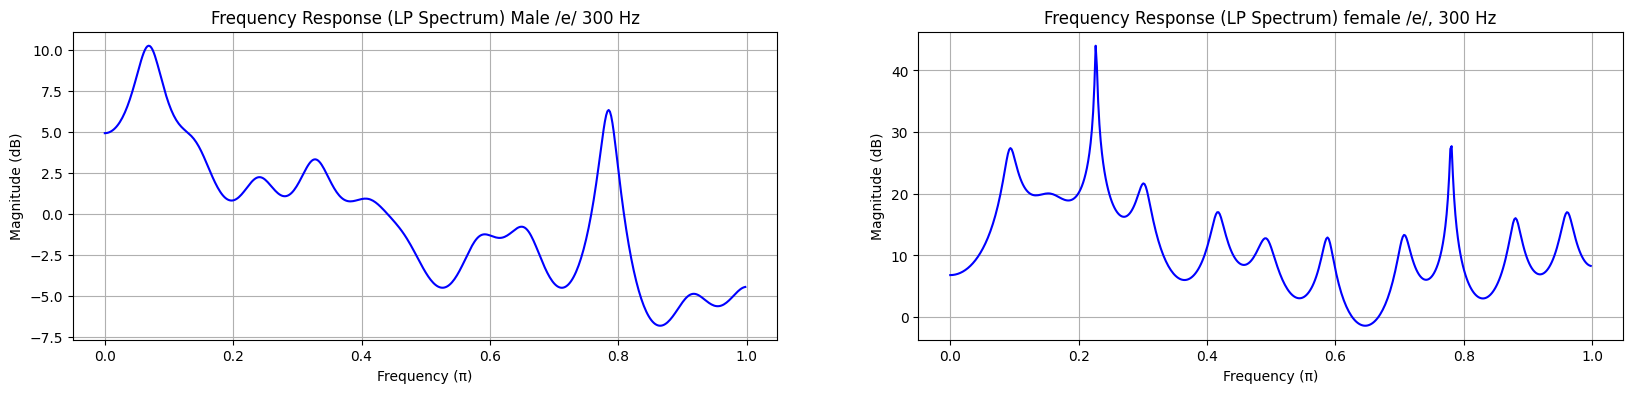

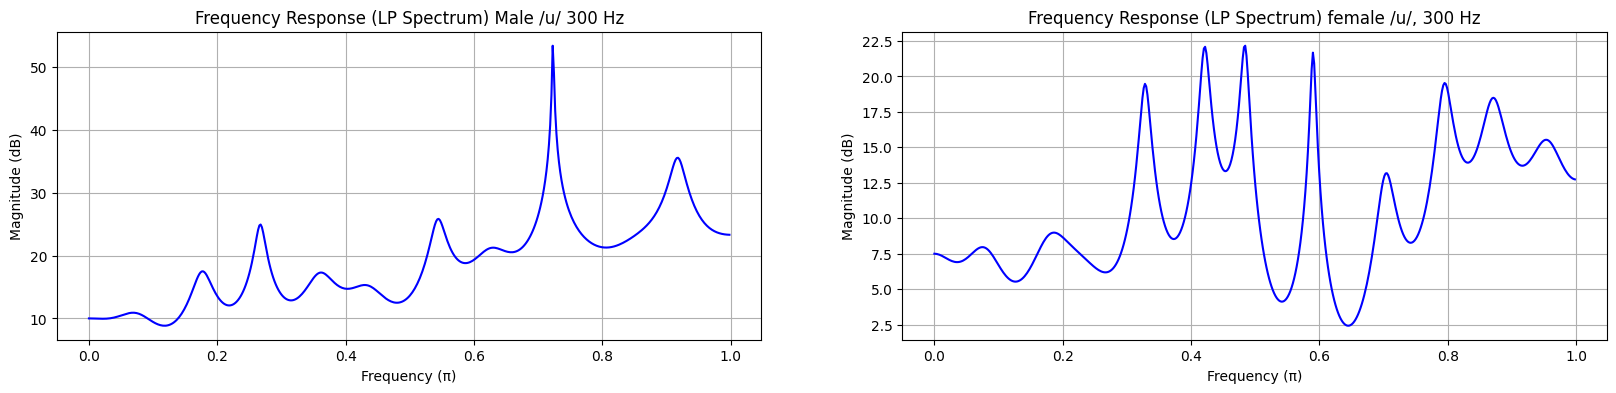

In [122]:
F0s = [100, 200, 300]  # Fundamental frequencies in Hz

for F0 in F0s:

  for vowel in ['a', 'e', 'u']:

    frameSize = 0.025
    frameShift = 0.01

    # Load the male vowel signal
    recording, rate = sf.read(f'male_{vowel}_{F0}.wav')
    sustained = Extract1D(recording, rate)
    Frames = FrameSig(sustained, rate, frameSize, frameShift)

    # Load the female vowel signal
    f_recording, f_rate = sf.read(f'female_{vowel}_{F0}.wav')
    f_sustained = Extract1D(f_recording, f_rate)
    f_Frames = FrameSig(f_sustained, f_rate, frameSize, frameShift)

    f_lpc_coeffs = estimate_a(f_Frames[0], 25)
    lpc_coeffs = estimate_a(Frames[0], 25)

    # Calculate the frequency response
    w, h = scipy.signal.freqz(b=[1], a=lpc_coeffs)
    f_w, f_h = scipy.signal.freqz(b=[1], a=f_lpc_coeffs)

    # Plot the magnitude spectrum
    fig, axes = plt.subplots(1, 2, figsize=(20, 4))

    axes[0].plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    axes[0].grid()
    axes[0].set_xlabel('Frequency (π)')
    axes[0].set_ylabel('Magnitude (dB)')
    axes[0].set_title(f'Frequency Response (LP Spectrum) Male /{vowel}/ {F0} Hz')

    axes[1].plot(f_w / np.pi, 20 * np.log10(abs(f_h)), 'b')
    axes[1].grid()
    axes[1].set_xlabel('Frequency (π)')
    axes[1].set_ylabel('Magnitude (dB)')
    axes[1].set_title(f'Frequency Response (LP Spectrum) female /{vowel}/, {F0} Hz')
    plt.show()

In [28]:
(recording,rate) = sf.read(f'male_a.wav')

#Extract 1 dimensional signal using voiced tags of the frames
sustained = Extract1D(recording, rate)

frameSize = 0.025
frameShift = 0.01
Frames = FrameSig(sustained, rate, frameSize, frameShift)

print('lpc coefficients from  pysptk.lpc:')
print(lpc(Frames[0], 25)[1:])

print('lpc coefficients with estimate_a function:')
print(estimate_a(Frames[0], 25))

lpc coefficients from  pysptk.lpc:
[-2.93914239e+00  4.39583295e+00 -4.19128191e+00  2.02828893e+00
  5.81471462e-02 -5.84109806e-01  2.75126267e-01  2.45379213e-01
 -1.60475882e-01 -2.32699261e-02 -4.99607336e-02 -1.14989501e-01
  6.22106794e-02  1.04738032e-02 -6.79191338e-02  1.49179742e-01
  1.04837543e-01 -1.70681370e-01  2.40316331e-03  1.45767761e-01
 -1.59451730e-01 -8.36921852e-02  2.45861199e-01 -2.26082782e-01
  9.65641748e-02]
lpc coefficients with estimate_a function:
[-2.93914239e+00  4.39583296e+00 -4.19128191e+00  2.02828893e+00
  5.81471398e-02 -5.84109803e-01  2.75126269e-01  2.45379207e-01
 -1.60475875e-01 -2.32699310e-02 -4.99607317e-02 -1.14989501e-01
  6.22106789e-02  1.04738034e-02 -6.79191337e-02  1.49179742e-01
  1.04837543e-01 -1.70681370e-01  2.40316334e-03  1.45767761e-01
 -1.59451730e-01 -8.36921852e-02  2.45861199e-01 -2.26082782e-01
  9.65641749e-02]


<dt> <h4>  1) Write down your observations on the synthesis of the vowels ('/a/', '/e/', '/u/') </h4> </dt>
<dd> <h4> a. Robotic voice </h4> </dd>
<dd> <h4> b.Spectra dosent match, too clean and consistent</h4> </dd>
<dd> <h4> c. closest audio is 100 Hz for males and 300 hz for females and dosent sound like actual voice </h4> </dd>


<dt> <h4> <b> Modules to Record Speech Signal </b> </h4> </dt>



In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio


<dt> <h4> <b> Recording the words "hot", "heat", and "hoot" </b> </h4> </dt>


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os

#### Please comment below line, if you already uploaded the 'recording.wav' in '/content/'
!rm recording.wav

if os.path.isfile('recording_a.wav') or os.path.isfile('recording_e.wav') or os.path.isfile('recording_u.wav'):
    print("wavefile exists, later part of the code uses 'recording_a,e,u.wav' as input speech")
else:
    print("There are no recordings ( recording_a.wav, recording_e.wav and recording_u.wav ) in the current directory, please record your voice")
    print("Recording vowel /a/ in hot")
    wav = record(3.0) #It will record three seconds of your speech ( For single vowels recording you can decrease the length )
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording_a.wav', 16000, fp_arr)
    print("Recording vowel /i/ in heat")
    wav = record(3.0) #It will record three seconds of your speech
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording_e.wav', 16000, fp_arr)
    print("Recording vowel /u/ in hoot")
    wav = record(3.0) #It will record three seconds of your speech
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording_u.wav', 16000, fp_arr)



